In [1]:
# Import libraries
import numpy as np
import math
import random
import pandas as pd

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm # linear regression

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import scanpy as sc
from gprofiler import GProfiler

import os

# Directory path
myDir = "/Users/junjie/Desktop/OneDrive - The University of Chicago (1)/Python"
os.chdir(myDir)
import ProxseqClasses as PC
import calculateweightedPPI as WPPI
import ProxseqFunctions as PF

#*****
mpl.rcdefaults()
# Set font to be arial
mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

#to store text as text, not as path
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'}
mpl.rcParams.update(new_rc_params)
#*****
# Seed number
np.random.seed(2025)
random.seed(2025)

In [348]:
import warnings
warnings.filterwarnings('ignore')

In [394]:
save_dir = '/Users/junjie/Library/CloudStorage/OneDrive-TheUniversityofChicago(1)/Experimental data/Glycan_proxseq/manuscript/fig_update_v2/'

In [3]:
adata = sc.read_h5ad('GPS/20250521/adata_raw_ctrl.h5ad')
annotation = pd.read_csv('GPS/20250521/ctrl_annotations_0801.csv', index_col=0)

In [4]:
#subset only CD4+ Naive, Tcm, Tem
# 1. Reindex to match adata.obs_names (cells not in annotation will be NaN)
adata.obs['manual_annotation'] = annotation['manual_annotation_reclustered'].reindex(adata.obs_names)

# 4. Subset to CD4 Naive, Tcm, Tem
cd4_subtypes = ["CD4+ Naive T cells", "CD4+ Central Memory", "CD4+ Effector Memory"]
adata_cd4 = adata[adata.obs['manual_annotation'].isin(cd4_subtypes)].copy()

In [5]:
# Load pseudotime values from CSV
cd4_pt_df = pd.read_csv("GPS/20250521/cd4_monocle3_PT.csv")  # contains 'cell_id' and 'pseudotime'

# Set index to match adata.obs_names
cd4_pt_df.index = cd4_pt_df['cell']

# Assign pseudotime
adata_cd4.obs['pseudotime'] = cd4_pt_df.loc[:, 'pseudotime']

In [6]:
# Create a boolean mask for inf, -inf, or NaN values in pseudotime
inf_or_nan_mask = np.isinf(adata_cd4.obs['pseudotime']) | np.isnan(adata_cd4.obs['pseudotime'])
# Filter out those rows
adata_cd4 = adata_cd4[~inf_or_nan_mask].copy()

In [7]:
#process data
adata_cd4.layers["counts"] = adata_cd4.X.copy() # preserve counts
sc.pp.normalize_total(adata_cd4)
sc.pp.log1p(adata_cd4)
adata_cd4.raw = adata_cd4.copy() # freeze the state in `.raw`
sc.pp.highly_variable_genes(adata_cd4, n_top_genes=4000)
adata_cd4 = adata_cd4[:, adata_cd4.var['highly_variable']]
sc.pp.scale(adata_cd4, max_value=10)
sc.tl.pca(adata_cd4, svd_solver='arpack')

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
sc.pp.neighbors(adata_cd4, n_neighbors=10, n_pcs=20)

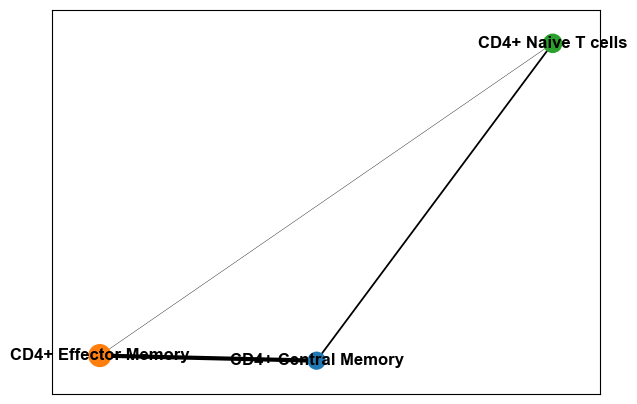

In [9]:
sc.tl.paga(adata_cd4, groups="manual_annotation")
sc.pl.paga(adata_cd4, color=["manual_annotation"])

In [10]:
# Select a root cell from the earliest time point
early_cells = adata_cd4.obs[adata_cd4.obs["manual_annotation"] == "CD4+ Naive T cells"].index  # Adjust based on actual time point labels
adata_cd4.uns["iroot"] = adata_cd4.obs.index.get_loc(early_cells[0])  # Set root cell index

# Run DPT with root cell
sc.tl.dpt(adata_cd4)

In [11]:
adata_cd4.obs['pseudotime']

AAACCCAAGTGTTGTC-1    16.577563
AAACCCACACCATTCC-1     4.940739
AAACGAAGTCCAAAGG-1    12.197670
AAACGCTAGCATTGTC-1    21.117029
AAAGAACGTTATCTTC-1    21.336010
                        ...    
TTTGGTTGTGGTCTCG-1     0.033939
TTTGTTGGTCTCAGAT-1     9.850429
TTTGTTGTCCGATGCG-1     0.033941
TTTGTTGTCGATGGAG-1    19.375193
TTTGTTGTCTTACCGC-1    12.424853
Name: pseudotime, Length: 3167, dtype: float64

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1229: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1276: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


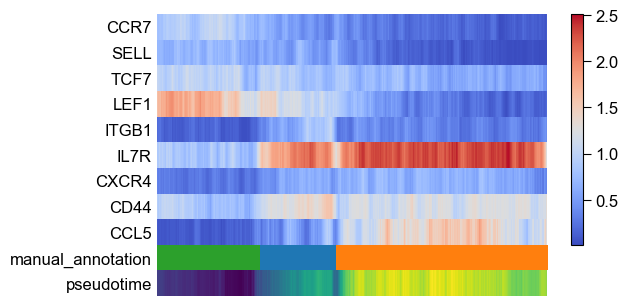

In [12]:
markers_gene = ["CCR7", "SELL", 'TCF7','LEF1', 'ITGB1',"IL7R",'CXCR4','CD44','CCL5']
plt.figure(figsize=(6.5, 3))
sc.pl.paga_path(
        adata_cd4,
        keys=markers_gene,
        nodes=['CD4+ Naive T cells','CD4+ Central Memory','CD4+ Effector Memory'],
        show_node_names=False,
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime"],
        show_colorbar=True,
        color_map="coolwarm",
        groups_key="manual_annotation",
        color_maps_annotations={"pseudotime": "viridis"},
        return_data=False,
        show=False
    )
# Show plot
plt.show()

In [13]:
# Define the CLR normalization function adapted from Seurat
def clr_function(column):
    # Filter out zeros for log transformation and only include positive values
    positive_values = column[column > 0]
    
    # Calculate the mean of log-transformed positive values
    mean_log = np.sum(np.log1p(positive_values)) / len(column)
    
    # Normalize by subtracting the exponential mean from each log-transformed value
    clr_values = np.log1p(column / np.exp(mean_log))
    
    return clr_values

In [14]:
#read lectin 
ctrl_lectin = pd.read_csv('GPS/20250521/ctrl_raw_lectin.csv', index_col=0)

In [15]:
ctrl_protein = pd.read_csv('GPS/20250521/ctrl_raw_protein.csv', index_col=0)

In [16]:
clr_ctrl_lectin = ctrl_lectin.apply(clr_function,axis=0)
clr_ctrl_protein = ctrl_protein.apply(clr_function, axis=0)

In [17]:
# Transpose so rows = cells, columns = lectins
ctrl_lectin_T = clr_ctrl_lectin.T

# Ensure index matches adata_cd4.obs_names
cd4_common_cells = adata_cd4.obs_names.intersection(ctrl_lectin_T.index)

# Subset both
adata_cd4 = adata_cd4[cd4_common_cells].copy()
ctrl_lectin_T = ctrl_lectin_T.loc[cd4_common_cells]

In [18]:
ctrl_protein_T = clr_ctrl_protein.T
ctrl_protein_T = ctrl_protein_T.loc[cd4_common_cells]

In [19]:
for lectin in ctrl_lectin_T.columns:
    new_key = f"LDT_{lectin}"
    # Add to .obs with the prefixed name
    adata_cd4.obs[new_key] = ctrl_lectin_T[lectin]

In [20]:
for protein in ctrl_protein_T.columns:
    new_key = f"ADT_{protein}"
    # Add to .obs with the prefixed name
    adata_cd4.obs[new_key] = ctrl_protein_T[protein]

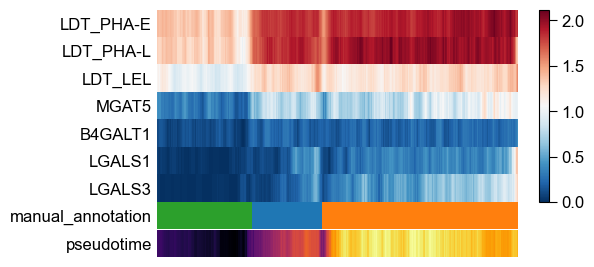

In [396]:
#lectin binding change alongside pseudotime
lectin = ["LDT_PHA-E", "LDT_PHA-L", 'LDT_LEL',"MGAT5",
         'B4GALT1','LGALS1','LGALS3']
plt.figure(figsize=(6, 2.5))
sc.pl.paga_path(
        adata_cd4,
        keys=lectin,
        nodes=['CD4+ Naive T cells','CD4+ Central Memory','CD4+ Effector Memory'],
        show_node_names=False,
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime"],
        show_colorbar=True,
        color_map="RdBu_r",
        groups_key="manual_annotation",
        color_maps_annotations={"pseudotime": "inferno"},
        return_data=False,
        show=False
    )
plt.savefig(save_dir + "cd4_lectin_trajectory.svg", format='svg', bbox_inches='tight', pad_inches=0)

In [386]:
adata_cd4

AnnData object with n_obs × n_vars = 3167 × 4000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'manual_annotation', 'pseudotime', 'dpt_pseudotime', 'LDT_PHA-L', 'LDT_PHA-E', 'LDT_DSL', 'LDT_ConA', 'LDT_PNA', 'LDT_MAL-I', 'LDT_MAL-II', 'LDT_SNA', 'LDT_DBA', 'LDT_ECA', 'LDT_AAL', 'LDT_LEL', 'LDT_GSL-II', 'LDT_Galectin-3', 'LDT_UEA-I', 'ADT_CD45', 'ADT_CD47', 'ADT_CD48', 'ADT_CD44', 'ADT_CD2', 'ADT_CD3', 'ADT_CD4', 'ADT_CD8', 'ADT_CD5', 'ADT_CD7', 'ADT_CD27', 'ADT_CD45RA', 'ADT_CD45RO', 'ADT_CD62L', 'ADT_CCR5', 'ADT_CCR7', 'ADT_CD127', 'ADT_CD25', 'ADT_CD28', 'ADT_CD137', 'ADT_CD154', 'ADT_CD150', 'ADT_CD38', 'ADT_PD1', 'ADT_TIM-3', 'ADT_LAG-3', 'ADT_CTLA-4', 'ADT_CD19', 'ADT_CD20', 'ADT_CD56', 'ADT_CD16', 'ADT_CD14', 'ADT_CD11b', 'ADT_CD11c', 'ADT_HLADR', 'ADT_CXCR3', 'ADT_CXCR4', 'ADT_CD11a', 'ADT_CD49e', 'ADT_CD29', 'ADT_ICAM-1', 'ADT_CD81', 'ADT_CD147'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_co

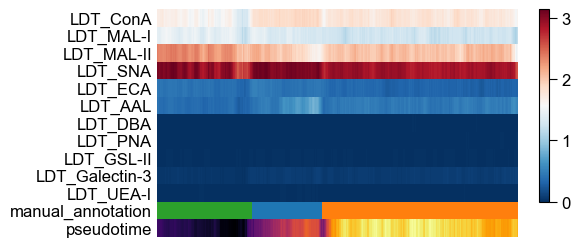

In [397]:
#lectin binding change alongside pseudotime
lectin = ['LDT_ConA','LDT_MAL-I', 'LDT_MAL-II', 'LDT_SNA','LDT_ECA', 'LDT_AAL','LDT_DBA','LDT_PNA', 'LDT_GSL-II', 'LDT_Galectin-3', 'LDT_UEA-I']
plt.figure(figsize=(6, 2.5))
sc.pl.paga_path(
        adata_cd4,
        keys=lectin,
        nodes=['CD4+ Naive T cells','CD4+ Central Memory','CD4+ Effector Memory'],
        show_node_names=False,
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime"],
        show_colorbar=True,
        color_map="RdBu_r",
        groups_key="manual_annotation",
        color_maps_annotations={"pseudotime": "inferno"},
        return_data=False,
        show=False
    )
plt.savefig(save_dir + "cd4_lectin_trajectory_others.svg", format='svg', bbox_inches='tight', pad_inches=0)

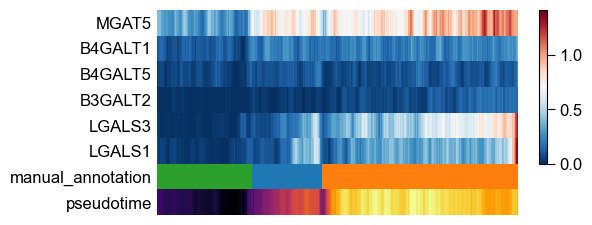

In [383]:
#lectin binding change alongside pseudotime
genes = ["MGAT5",
         'B4GALT1', 'B4GALT5', 'B3GALT2','LGALS3', 'LGALS1']
plt.figure(figsize=(6, 2))
sc.pl.paga_path(
        adata_cd4,
        keys=genes,
        nodes=['CD4+ Naive T cells','CD4+ Central Memory','CD4+ Effector Memory'],
        show_node_names=False,
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime"],
        show_colorbar=True,
        color_map="RdBu_r",
        groups_key="manual_annotation",
        color_maps_annotations={"pseudotime": "inferno"},
        return_data=False,
        show=False
    )
plt.show()
#plt.savefig("paga_path_cd4_lectin.svg", format='svg', bbox_inches='tight', pad_inches=0.5)

In [398]:
glyco_genes = [
    "A4GALT", "A4GNT", "ABO", "AGA", "ALG1", "ALG10", "ALG10B", "ALG11", "ALG12", "ALG13",
    "ALG14", "ALG2", "ALG3", "ALG5", "ALG6", "ALG8", "ALG9", "B3GALNT1", "B3GALNT2", "B3GALT1",
    "B3GALT2", "B3GALT4", "B3GALT5", "B3GALT6", "B3GAT1", "B3GAT2", "B3GAT3", "B3GLCT", "B3GNT2",
    "B3GNT3", "B3GNT4", "B3GNT5", "B3GNT6", "B3GNT7", "B3GNT8", "B3GNT9", "B3GNTL1", "B4GALNT1",
    "B4GALNT2", "B4GALNT3", "B4GALNT4", "B4GALT1", "B4GALT2", "B4GALT3", "B4GALT4", "B4GALT5",
    "B4GALT6", "B4GALT7", "B4GAT1", "C1GALT1", "C1GALT1C1", "CHPF", "CHPF2", "CHST1", "CHST10",
    "CHST11", "CHST12", "CHST13", "CHST14", "CHST15", "CHST2", "CHST3", "CHST4", "CHST5", "CHST6",
    "CHST7", "CHST8", "CHST9", "CHSY1", "CHSY3", "CMAS", "COLGALT1", "COLGALT2", "CSGALNACT1",
    "CSGALNACT2", "DAD1", "DDOST", "DPAGT1", "DPM1", "DPM2", "DPM3", "DPY19L1", "DPY19L2",
    "DPY19L3", "DPY19L4", "DSE", "DSEL", "EGOT", "ENGASE", "EOGT", "EXT1", "EXT2", "EXTL1",
    "EXTL2", "EXTL3", "FKRP", "FKTN", "FPGT", "FUCA1", "FUCA2", "FUK", "FUT1", "FUT10", "FUT11",
    "FUT2", "FUT3", "FUT4", "FUT5", "FUT6", "FUT7", "FUT8", "FUT9", "GAL3ST1", "GAL3ST2",
    "GAL3ST3", "GAL3ST4", "GALC", "GALE", "GALK1", "GALK2", "GALNS", "GALNT1", "GALNT10",
    "GALNT11", "GALNT12", "GALNT13", "GALNT14", "GALNT15", "GALNT16", "GALNT18", "GALNT2",
    "GALNT3", "GALNT4", "GALNT5", "GALNT6", "GALNT7", "GALNT8", "GALNT9", "GALNTL5", "GALNTL6",
    "GALT", "GANAB", "GBA", "GBA2", "GBA3", "GBGT1", "GCNT1", "GCNT2", "GCNT3", "GCNT4", "GCNT6",
    "GCNT7", "GLA", "GLB1", "GLCE", "GM2A", "GMDS", "GMPPA", "GMPPB", "GNB1", "GNB2L1", "GNE",
    "GNPDA1", "GNPNAT1", "GNS", "GPI", "GUSB", "GXYLT1", "GXYLT2", "HAS1", "HAS2", "HAS3", "HEXA",
    "HEXB", "HEXD", "HGSNAT", "HK1", "HK2", "HK3", "HPSE", "HPSE2", "HS2ST1", "HS3ST1", "HS3ST2",
    "HS3ST3A1", "HS3ST3B1", "HS3ST4", "HS3ST5", "HS3ST6", "HS6ST1", "HS6ST2", "HS6ST3", "HYAL1",
    "HYAL2", "HYAL3", "HYAL4", "IDS", "IDUA", "KHK", "LARGE1", "LARGE2", "LFNG", "LGALS1",
    "LGALS12", "LGALS13", "LGALS14", "LGALS16", "LGALS2", "LGALS3", "LGALS3BP", "LGALS4",
    "LGALS7", "LGALS7B", "LGALS8", "LGALS9", "LGALS9B", "LGALS9C", "MAN1A1", "MAN1A2", "MAN1B1",
    "MAN1C1", "MAN2A1", "MAN2A2", "MAN2B1", "MAN2B2", "MAN2C1", "MANBA", "MFNG", "MGAT1", "MGAT2",
    "MGAT3", "MGAT4A", "MGAT4B", "MGAT4C", "MGAT4D", "MGAT5", "MGAT5B", "MGEA5", "MOGS", "MPI",
    "MUC1", "MUC12", "MUC13", "MUC15", "MUC16", "MUC17", "MUC19", "MUC2", "MUC20", "MUC21",
    "MUC3A", "MUC3B", "MUC4", "MUC5AC", "MUC5B", "MUC6", "MUC7", "MUC8", "MUCL1", "NAGK", "NAGLU",
    "NANP", "NANS", "NDST1", "NDST2", "NDST3", "NDST4", "NEU1", "NEU2", "NEU3", "NEU4", "NPL",
    "OGT", "OVGP1", "PGAP4", "PGM1", "PIGA", "PIGB", "PIGC", "PIGH", "PIGM", "PIGP", "PIGQ",
    "PIGV", "PIGZ", "PMM1", "PMM2", "POFUT1", "POFUT2", "POGLUT1", "POGLUT2", "POGLUT3",
    "POMGNT1", "POMGNT2", "POMK", "POMT1", "POMT2", "PSAP", "RENBP", "RFNG", "RFT1", "RPN1",
    "RPN2", "RXYLT1", "SGSH", "SLC33A1", "SLC35A1", "SLC35A2", "SLC35A3", "SLC35B1", "SLC35B2",
    "SLC35B3", "SLC35C1", "SLC35D1", "SLC35D2", "SPAM1", "ST3GAL1", "ST3GAL2", "ST3GAL3",
    "ST3GAL4", "ST3GAL5", "ST3GAL6", "ST6GAL1", "ST6GAL2", "ST6GALNAC1", "ST6GALNAC2",
    "ST6GALNAC3", "ST6GALNAC4", "ST6GALNAC5", "ST6GALNAC6", "ST8SIA1", "ST8SIA2", "ST8SIA3",
    "ST8SIA4", "ST8SIA5", "ST8SIA6", "STS", "STT3A", "STT3B", "SULF1", "SULF2", "TMEM241",
    "TMTC1", "TMTC2", "TMTC3", "TMTC4", "TPST1", "TPST2", "TSTA3", "TUSC3", "UAP1", "UGCG",
    "UGCGL1", "UGCGL2", "UGDH", "UGP2", "UGT1A1", "UGT2A1", "UGT2B10", "UGT2B17", "UGT2B28",
    "UGT2B4", "UGT8", "UST", "UXS1", "WBSCR17", "XXYLT1", "XYLT1", "XYLT2"
]

In [399]:
# Filter cells
adata_sub = adata_cd4[adata_cd4.obs["manual_annotation"].isin(["CD4+ Naive T cells", "CD4+ Effector Memory"])].copy()

# Set group labels
adata_sub.obs["group"] = adata_sub.obs["manual_annotation"]

In [400]:
sc.tl.rank_genes_groups(
    adata_sub,
    groupby="group",
    groups=["CD4+ Effector Memory"],
    reference="CD4+ Naive T cells",
    method="wilcoxon",
    pts=True
)

de_result = sc.get.rank_genes_groups_df(adata_sub, group="CD4+ Effector Memory")
de_glyco = de_result[de_result["names"].isin(glyco_genes)].copy()

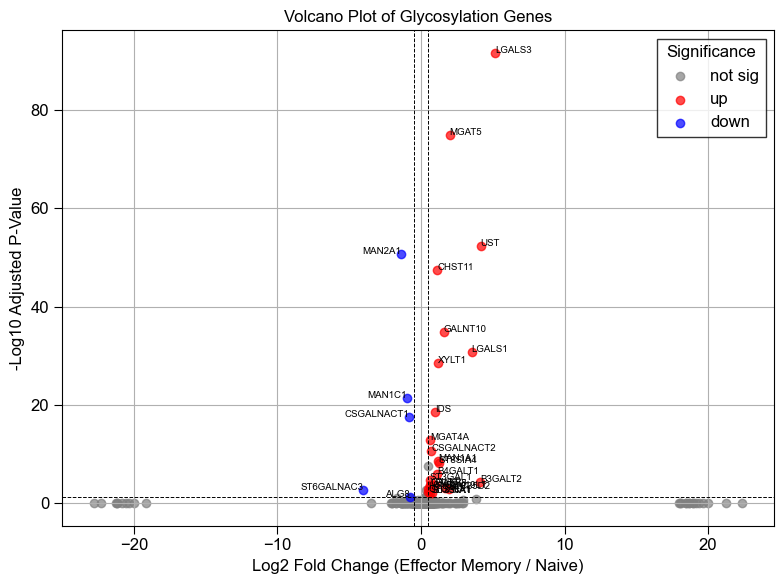

In [405]:
# Compute volcano plot axes
de_glyco["-log10(padj)"] = -np.log10(de_glyco["pvals_adj"] + 1e-300)

# Assign significance
de_glyco["significant"] = "not sig"
de_glyco.loc[(de_glyco["logfoldchanges"] > 0.5) & (de_glyco["pvals_adj"] < 0.05), "significant"] = "up"
de_glyco.loc[(de_glyco["logfoldchanges"] < -0.5) & (de_glyco["pvals_adj"] < 0.05), "significant"] = "down"

# Set color mapping
color_map = {
    "not sig": "gray",
    "up": "red",
    "down": "blue"
}

# Plot
plt.figure(figsize=(8, 6))
for sig in ["not sig", "up", "down"]:
    df = de_glyco[de_glyco["significant"] == sig]
    plt.scatter(df["logfoldchanges"], df["-log10(padj)"], c=color_map[sig], label=sig, alpha=0.7)

# Add labels to significantly changed glycosylation genes
for _, row in de_glyco.iterrows():
    if row["significant"] != "not sig":
        plt.text(
            row["logfoldchanges"], row["-log10(padj)"], row["names"],
            fontsize=7, ha='right' if row["logfoldchanges"] < 0 else 'left'
        )

# Threshold lines
plt.axhline(-np.log10(0.05), linestyle='--', color='black', linewidth=0.7)
plt.axvline(0.5, linestyle='--', color='black', linewidth=0.7)
plt.axvline(-0.5, linestyle='--', color='black', linewidth=0.7)

# Labels
plt.xlabel("Log2 Fold Change (Effector Memory / Naive)")
plt.ylabel("-Log10 Adjusted P-Value")
plt.title("Volcano Plot of Glycosylation Genes")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Significance")
plt.show()


In [406]:
de_glyco[de_glyco['significant'] == 'up'].sort_values('pvals_adj', ascending=True) 

names     scores  logfoldchanges         pvals     pvals_adj  \
25        LGALS3  20.711502        5.164188  2.728210e-95  2.289680e-92   
42         MGAT5  18.732304        2.002540  2.699759e-78  1.336242e-75   
70           UST  15.683605        4.155344  1.958159e-55  5.323710e-53   
83        CHST11  14.944778        1.117944  1.684508e-50  3.965372e-48   
115      GALNT10  12.846165        1.594705  9.038124e-38  1.578850e-35   
132       LGALS1  12.108943        3.536909  9.470710e-34  1.468378e-31   
141        XYLT1  11.677915        1.201472  1.653011e-31  2.390118e-29   
205          IDS   9.494970        0.967207  2.202744e-21  2.323474e-19   
286       MGAT4A   7.954454        0.617431  1.799228e-15  1.447104e-13   
343   CSGALNACT2   7.254754        0.716757  4.023925e-13  2.769120e-11   
397       MAN1A1   6.618115        1.217515  3.638065e-11  2.174166e-09   
409      ST8SIA4   6.488638        1.224189  8.661575e-11  5.035976e-09   
519      B4GALT1   5.556555        1.152044  2.751515e-08  1.293849e-06   
600      ST3GAL1   5.054525        0.616123  4.314637e-07  1.769331e-05   
633      B3GALT2   4.876088        4.142085  1.082102e-06  4.207011e-05   
711        GALK2   4.567888        0.659775  4.926639e-06  1.721247e-04   
730         GLB1   4.503020        0.952224  6.699459e-06  2.284800e-04   
759       LGALS8   4.393837        0.629845  1.113674e-05  3.668472e-04   
798      DPY19L1   4.190032        1.707376  2.789147e-05  8.718851e-04   
809      SLC35D2   4.139497        1.947024  3.480684e-05  1.069867e-03   
832       HGSNAT   4.069957        0.510381  4.702186e-05  1.410510e-03   
935      C1GALT1   3.773021        0.500410  1.612825e-04  4.348096e-03   
984      ST8SIA1   3.642598        0.797216  2.699003e-04  6.955789e-03   
1009     SLC33A1   3.591919        0.662814  3.282519e-04  8.268284e-03   

      pct_nz_group  -log10(padj) significant  
25        0.525276     91.640225          up  
42        0.683324     74.874115          up  
70        0.415456     52.273786          up  
83        0.852411     47.401716          up  
115       0.535154     34.801659          up  
132       0.337013     30.833162          up  
141       0.605462     28.621581          up  
205       0.549680     18.633862          up  
286       0.707147     12.839500          up  
343       0.556072     10.557658          up  
397       0.317257      8.662707          up  
409       0.296339      8.297916          up  
519       0.267868      5.888117          up  
600       0.438117      4.752191          up  
633       0.128995      4.376026          up  
711       0.357350      3.764157          up  
730       0.249855      3.641152          up  
759       0.361999      3.435515          up  
798       0.152237      3.059541          up  
809       0.139454      2.970670          up  
832       0.418361      2.850624          up  
935       0.395119      2.361701          up  
984       0.229518      2.157654          up  
1009      0.286461      2.082585          up

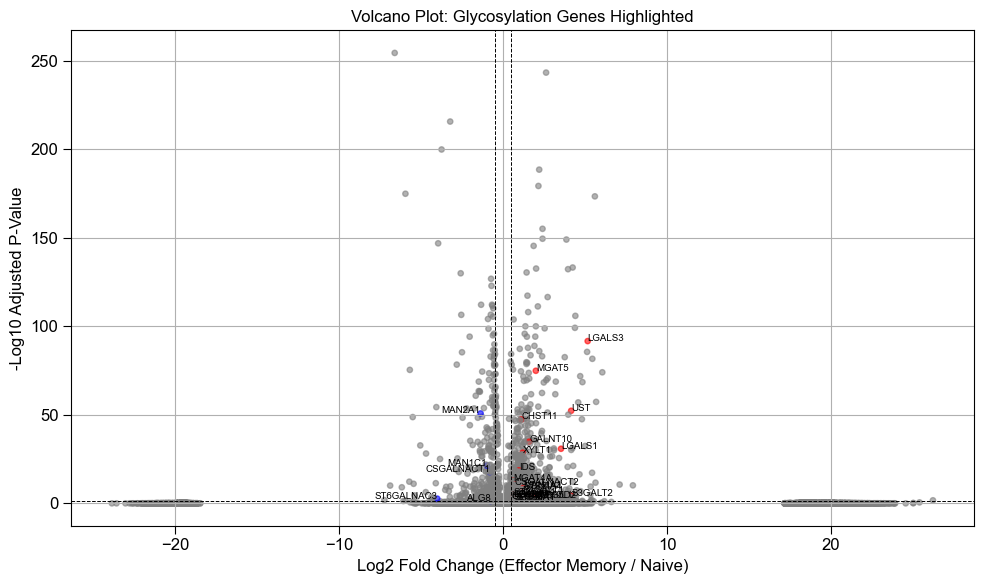

In [408]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Prepare DE data
df = de_result.copy()
df["-log10(padj)"] = -np.log10(df["pvals_adj"] + 1e-300)

# Step 2: Mark all genes as gray by default
df["color"] = "gray"

# Step 3: Highlight significant glycosylation-related genes
is_glyco = df["names"].isin(glyco_genes)
is_sig_up = (df["logfoldchanges"] > 0.5) & (df["pvals_adj"] < 0.05)
is_sig_down = (df["logfoldchanges"] < -0.5) & (df["pvals_adj"] < 0.05)

df.loc[is_glyco & is_sig_up, "color"] = "red"
df.loc[is_glyco & is_sig_down, "color"] = "blue"

# Step 4: Volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(df["logfoldchanges"], df["-log10(padj)"], c=df["color"], s=15, alpha=0.6)

# Step 5: Annotate only labeled glycosylation genes
for _, row in df.loc[is_glyco & (is_sig_up | is_sig_down)].iterrows():
    plt.text(
        row["logfoldchanges"], row["-log10(padj)"], row["names"],
        fontsize=7, ha='right' if row["logfoldchanges"] < 0 else 'left'
    )

# Step 6: Add reference lines
plt.axhline(-np.log10(0.05), linestyle='--', color='black', linewidth=0.7)
plt.axvline(0.5, linestyle='--', color='black', linewidth=0.7)
plt.axvline(-0.5, linestyle='--', color='black', linewidth=0.7)

# Step 7: Labels and formatting
plt.xlabel("Log2 Fold Change (Effector Memory / Naive)")
plt.ylabel("-Log10 Adjusted P-Value")
plt.title("Volcano Plot: Glycosylation Genes Highlighted")
plt.grid(True)
plt.tight_layout()
plt.show()

In [429]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from adjustText import adjust_text

def volcano_plot(
    de_df,
    logfc_col='logfoldchanges',
    pval_col='pvals_adj',
    gene_col='names',
    logfc_thresh=0.5,
    pval_thresh=0.05,
    label_genes=None,
    figsize=(8,6),
    title='Volcano Plot',
    ax=None,
    base_dot_size=20,
    highlight_dot_size=60,
    up_color='#E64B35',
    down_color='#4DBBD5',
    default_color='gray'
):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    de_df = de_df.copy()
    de_df[pval_col] = de_df[pval_col].replace(0, 1e-300)
    de_df['neg_log10_pval'] = -np.log10(de_df[pval_col])

    # Define color logic
    def assign_color(row):
        if row[logfc_col] >= logfc_thresh and row[pval_col] < pval_thresh:
            return up_color
        elif row[logfc_col] <= -logfc_thresh and row[pval_col] < pval_thresh:
            return down_color
        else:
            return default_color

    de_df['color'] = de_df.apply(assign_color, axis=1)

    # Plot all points
    ax.scatter(
        de_df[logfc_col],
        de_df['neg_log10_pval'],
        c=de_df['color'],
        s=base_dot_size,
        alpha=0.7,
        edgecolor='none',
        rasterized=True
    )

    # Threshold lines
    ax.axhline(-np.log10(pval_thresh), color='black', linestyle='--', linewidth=1)
    ax.axvline(logfc_thresh, color='black', linestyle='--', linewidth=1)
    ax.axvline(-logfc_thresh, color='black', linestyle='--', linewidth=1)

    # Label selected genes
    texts = []
    if label_genes is not None:
        subset = de_df[de_df[gene_col].isin(label_genes)]
        for _, row in subset.iterrows():
            texts.append(
                ax.text(
                    row[logfc_col],
                    row['neg_log10_pval'],
                    row[gene_col],
                    fontsize=8,
                    ha='right' if row[logfc_col] < 0 else 'left',
                    va='bottom',
                    color='black'
                )
            )
            ax.scatter(
                row[logfc_col],
                row['neg_log10_pval'],
                c=row['color'],
                s=highlight_dot_size,
                edgecolor='k',
                linewidth=1.0,
                zorder=3,
                rasterized=True
            )

    # Adjust text positions
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='-', color='black')
    )

    # Final plot settings
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 Adjusted P-value')
    ax.set_title(title)
    ax.set_xlim(-10, 10)
    ax.set_ylim(-5, 100)

    # Dot-style legend
    legend_elements = [
        mlines.Line2D([], [], color=default_color, marker='o', linestyle='None',
                      markersize=8, label='NS'),
        mlines.Line2D([], [], color=down_color, marker='o', linestyle='None',
                      markersize=8, label='Down'),
        mlines.Line2D([], [], color=up_color, marker='o', linestyle='None',
                      markersize=8, label='Up')
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=False)

    plt.tight_layout()
    return ax

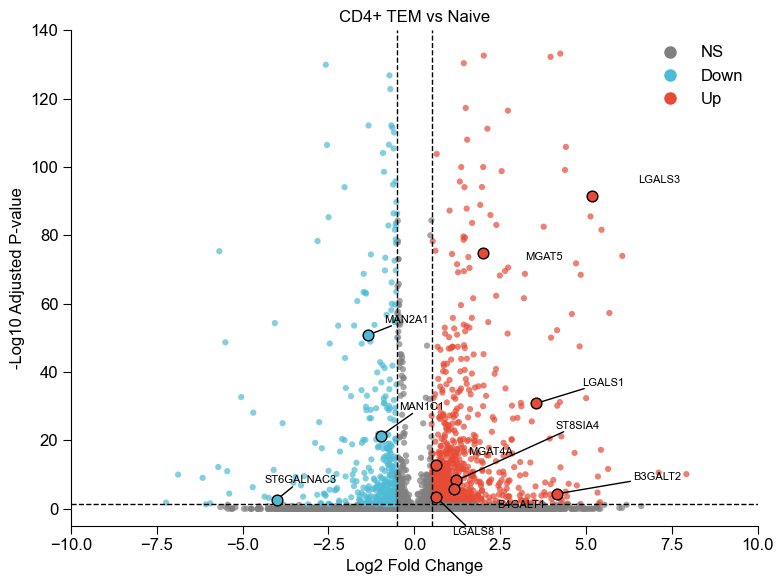

In [410]:
volcano_plot(
    df,
    label_genes=['LGALS3','MGAT5','LGALS1','B3GALT2','B4GALT1','ST8SIA4','LGALS8','MGAT4A',
                 'MAN2A1','MAN1C1','ST6GALNAC3'],
    logfc_thresh=0.5,
    pval_thresh=0.05,
    title='CD4+ TEM vs Naive'
)

sns.despine()
plt.savefig(save_dir + "volcano_plot_TEM_Naive.svg", format='svg', bbox_inches='tight', pad_inches=0)

In [71]:
#read PLA data
#raw count data
ctrl_data = pd.read_csv('GPS/20250521/Ctrl_count_matrix.txt.gz',sep="\t",index_col=0)
all_protein_list = [
    "CD45", "CD47", "CD48", "CD44", "CD2", "CD3", "CD4", "CD8", "CD5", "CD7",
    "CD27", "CD45RA", "CD45RO", "CD62L", "CCR5", "CCR7", "CD127", "CD25", "CD28",
    "CD137", "CD154", "CD150", "CD38", "PD1", "TIM-3", "LAG-3", "CTLA-4",
    "CD19", "CD20", "CD56", "CD16", "CD14", "CD11b", "CD11c", "HLADR", "CXCR3",
    "CXCR4", "CD11a", "CD49e", "CD29", "ICAM-1", "CD81", "CD147", "free_oligo"]

all_lectin_list = [
    "PHA-L", "PHA-E", "DSL", "ConA", "PNA", "MAL-I", "MAL-II", "SNA", "DBA",
    "ECA", "AAL", "LEL", "GSL-II", "Galectin-3", "UEA-I", "free_oligo"]
# Construct the full index list
index_list = [f'{protein}:{lectin}' for protein in all_protein_list for lectin in all_lectin_list]

# Reindex both datasets to ensure all indices exist, fill missing with 0
ctrl_target = ctrl_data.reindex(index_list).fillna(0)

# Remove the 'free_oligo:free_oligo' row if present
ctrl_target = ctrl_target.loc[~ctrl_target.index.str.contains('free_oligo:free_oligo')]
clr_pla = ctrl_target.apply(clr_function, axis=0)

In [72]:
#match cell index based on PT results
adata_pla_cd4 = sc.AnnData(clr_pla.T.loc[cd4_common_cells,:])
adata_pla_cd4.obs["celltype"] = adata_cd4.obs.loc[cd4_common_cells, "manual_annotation"]

In [67]:
#match cell index based on annotation
adata_pla_cd4 = sc.AnnData(clr_pla.T)
adata_pla_cd4.obs['celltype'] = annotation['manual_annotation_reclustered'].reindex(adata_pla_cd4.obs_names)

# Step 3: Drop cells with NaN in celltype
adata_pla_cd4 = adata_pla_cd4[adata_pla_cd4.obs['celltype'].notna()].copy()

# Step 4: Keep only CD4-related cells
cd4_mask = adata_pla_cd4.obs['celltype'].str.contains('CD4')
adata_pla_cd4 = adata_pla_cd4[cd4_mask].copy()


In [73]:
sc.pp.scale(adata_pla_cd4, max_value=10)

In [74]:
sc.tl.rank_genes_groups(
    adata_pla_cd4,
    groupby="celltype",
    method="wilcoxon",
)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfold

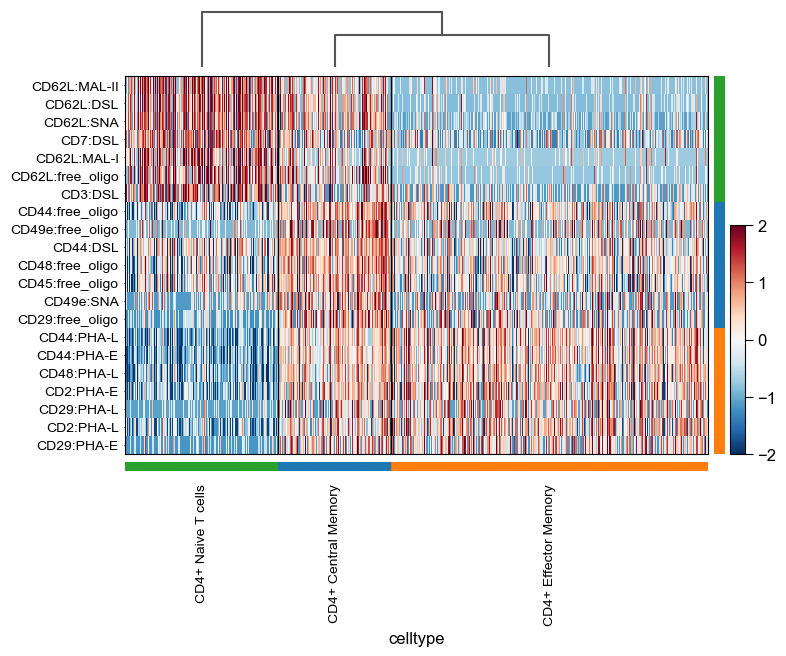

In [412]:
sc.pl.rank_genes_groups_heatmap(
    adata_pla_cd4,
    n_genes=7,
    cmap="RdBu_r",
    swap_axes=True,
    figsize=(8, 6),
    use_raw=False,
    vmax=2, vmin=-2,
    show=False
)
plt.savefig(save_dir+'CD4_PLA_heatmap.svg', format='svg', bbox_inches='tight', pad_inches=0)

In [89]:
adata_pla_cd4.obs['pseudotime'] = adata_cd4.obs['pseudotime']

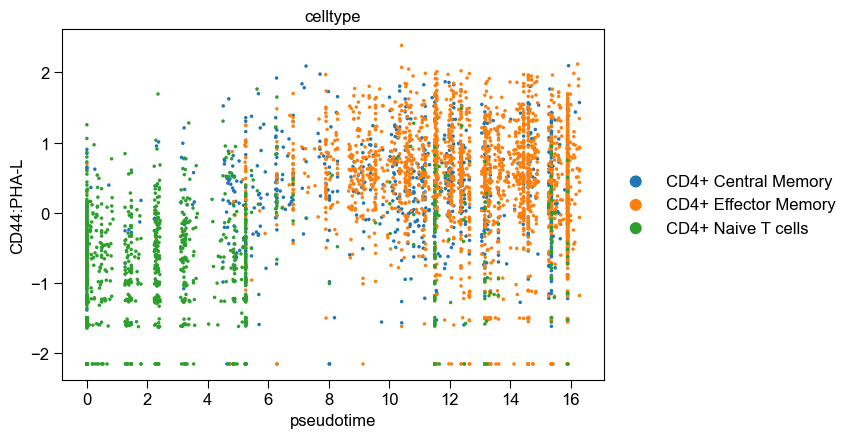

In [97]:
# Ensure celltype is a categorical variable
adata_pla_cd4.obs['celltype'] = adata_pla_cd4.obs['celltype'].astype('category')

# Get unique cell types
celltypes = adata_pla_cd4.obs['celltype'].cat.categories.tolist()

# Map each cell type to a color from seaborn
palette_dict = dict(zip(celltypes, sns.color_palette('tab10', n_colors=len(celltypes))))

# Plot
sc.pl.scatter(
    adata_pla_cd4,
    x='pseudotime',
    y='CD44:PHA-L',
    color='celltype',
    show=True
)

In [513]:
import scanpy as sc
import numpy as np
import pandas as pd
from gprofiler import GProfiler
import matplotlib.pyplot as plt

def extract_DEG_and_enrich_pathways(
    adata_weight,
    adata_rna,
    temra_label = 'CD8+ Effector Memory RA',
    marker='CD44:PHA-L',
    low_pct=25,
    high_pct=75,
    plot=True,
    top_n_genes=100,
    organism='hsapiens'
):
    """
    Identify DEGs between high and low PLA signal cells,
    and perform pathway enrichment using g:Profiler.

    Parameters:
    - adata_weight: AnnData with marker expression (e.g., PLA/protein)
    - adata_rna: AnnData with gene expression
    - marker: Marker used to define high/low signal
    - low_pct, high_pct: Percentile cutoffs for marker signal
    - plot: Whether to show volcano plot
    - top_n_genes: Number of top DEGs to send to enrichment
    - organism: g:Profiler species name (e.g., 'hsapiens')

    Returns:
    - combined AnnData with DE result
    - DEG DataFrame
    - g:Profiler enrichment result DataFrame
    """
    
    temra_adata = adata_weight[adata_weight.obs['celltype'] == temra_label].copy()
    
    marker_values = temra_adata[:, marker].X
    if hasattr(marker_values, "toarray"):  # handle sparse matrix
        marker_values = marker_values.toarray()

    marker_values = marker_values.flatten()  # ensure 1D

    # Determine thresholds
    high_thresh = np.percentile(marker_values, high_pct)
    low_thresh = np.percentile(marker_values, low_pct)
    
    # Get indices
    high_mask = marker_values >= high_thresh
    low_mask = marker_values <= low_thresh
    
    high_barcodes = temra_adata.obs_names[high_mask]
    low_barcodes = temra_adata.obs_names[low_mask]

    # Subset RNA data
    high_rna = adata_rna[adata_rna.obs_names.isin(high_barcodes)].copy()
    low_rna = adata_rna[adata_rna.obs_names.isin(low_barcodes)].copy()
    high_rna.obs['group'] = 'high'
    low_rna.obs['group'] = 'low'

    # Combine and run DEG
    combined = sc.concat([high_rna, low_rna], label='group', keys=['high', 'low'], index_unique=None)

    return combined

In [514]:
test = extract_DEG_and_enrich_pathways(
    adata_weight=adata_pla_cd8,
    adata_rna=adata_cd8,
    temra_label = 'CD8+ Effector Memory RA',
    marker='CD45:LEL',
    low_pct=15,
    high_pct=85,
)

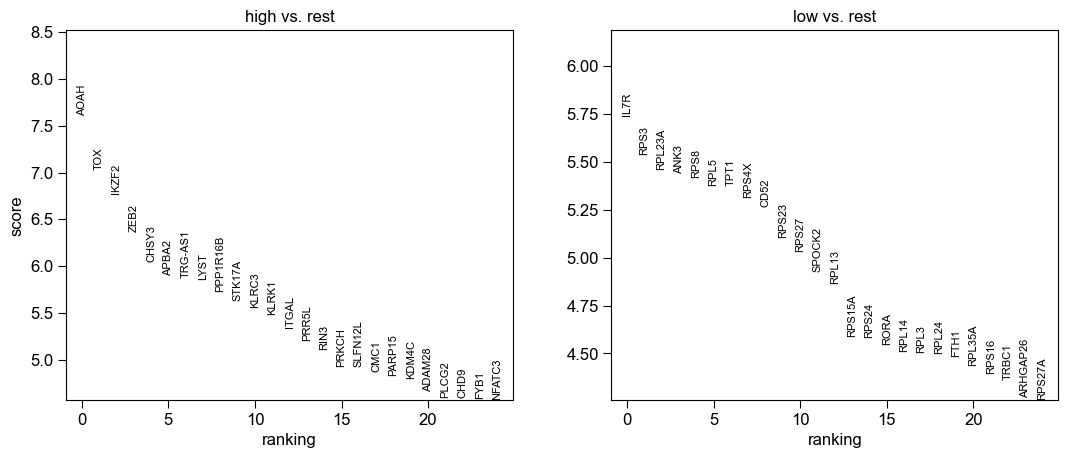

In [515]:
sc.tl.rank_genes_groups(test, groupby="group", method="wilcoxon")
sc.pl.rank_genes_groups(test, n_genes=25, sharey=False) 

In [516]:
#convert to dataframe
results = test.uns['rank_genes_groups']
('0', '1', '2', '3', '4')

out = np.array([[0,0,0,0,0]])
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group])).astype('object'))).T))



markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])

#markers = markers[(markers.pval_adj < 0.05) & (markers.lfc > 0.5)]

In [252]:
de_result = sc.get.rank_genes_groups_df(test, group="high")

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/get/get.py:66: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()


In [517]:
markers_high = markers[(markers.cluster=='high') & (abs(markers.scores) > 0.5)].drop_duplicates(subset="Gene")

In [518]:
markers_high

Gene    scores  pval_adj       lfc cluster
0        AOAH  7.610032       0.0  1.234231    high
1         TOX  7.027399       0.0  1.699034    high
2       IKZF2  6.773757       0.0  1.553267    high
3        ZEB2  6.370912  0.000002  0.917697    high
4       CHSY3  6.041922  0.000012  3.707069    high
...       ...       ...       ...       ...     ...
38601    RPS8 -5.416767  0.000138 -0.541132    high
38602    ANK3 -5.438401   0.00013 -1.540422    high
38603  RPL23A -5.457052  0.000125 -0.461198    high
38604    RPS3  -5.53389  0.000093 -0.414412    high
38605    IL7R -5.740535   0.00004 -3.085078    high

[6662 rows x 5 columns]

Text(0.5, 1.0, 'Top Up/Down Regulated Genes with Significance')

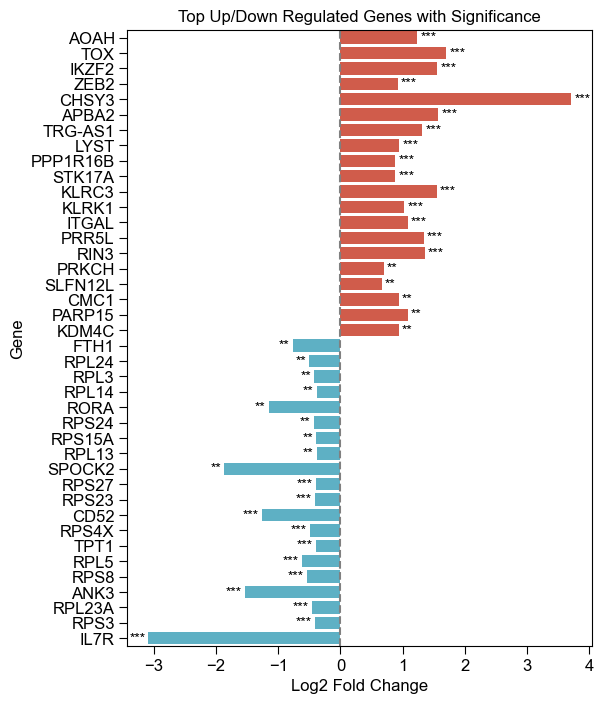

In [493]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define significance stars
def get_pval_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Sort and select top/bottom genes
top_n = 20
df_sorted = markers_high.sort_values("scores", ascending=False)
top_genes = pd.concat([df_sorted.head(top_n), df_sorted.tail(top_n)]).copy()

# Assign color and asterisk
top_genes['color'] = ['#E64B35' if x > 0 else '#4DBBD5' for x in top_genes['lfc']]
top_genes['star'] = top_genes['pval_adj'].apply(get_pval_star)

# Plot
plt.figure(figsize=(6, 8))
ax = sns.barplot(
    data=top_genes,
    y='Gene',
    x='lfc',
    palette=top_genes['color']
)

# Add p-value stars
for i, (lfc, star) in enumerate(zip(top_genes['lfc'], top_genes['star'])):
    ax.text(
        lfc + (0.05 if lfc > 0 else -0.05),  # small offset
        i,
        star,
        color='black',
        va='center',
        ha='left' if lfc > 0 else 'right',
        fontsize=10
    )

plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Log2 Fold Change")
plt.title("Top Up/Down Regulated Genes with Significance")
#plt.savefig(save_dir + "de_cd8_cd45_lel.svg", format="svg", bbox_inches='tight', pad_inches=0)

In [519]:
rnk = markers_high[["Gene", "scores"]].sort_values("scores", ascending=False)

# Write to rnk file
gsea_dir = "GPS/20250521/gsea_results/CD8_TEMRA_LEL"  # example path
lectin_name = "CD45:LEL"  # example name
os.makedirs(gsea_dir, exist_ok=True)
rnk_path = os.path.join(gsea_dir, f"{lectin_name}_ranked.rnk")
rnk.to_csv(rnk_path, sep="\t", index=False, header=False)

In [520]:
import gseapy as gp

pre_res = gp.prerank(
    rnk=rnk_path,
    gene_sets='GPS/20250521/gsea_results/c5.go.bp.v2025.1.Hs.symbols.gmt',
    outdir=gsea_dir,
    format='png',
    min_size=15,
    max_size=500,
    permutation_num=1000,
    seed=42,
    verbose=True,
)

# Process the result
res_df = pre_res.res2d.copy()
res_df.index = res_df.index.astype(str)

2025-08-06 17:03:12,666 [WARNING] Duplicated values found in preranked stats: 53.74% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-08-06 17:03:12,667 [INFO] Parsing data files for GSEA.............................
2025-08-06 17:03:12,853 [INFO] 5332 gene_sets have been filtered out when max_size=500 and min_size=15
2025-08-06 17:03:12,854 [INFO] 2251 gene_sets used for further statistical testing.....
2025-08-06 17:03:12,854 [INFO] Start to run GSEA...Might take a while..................
2025-08-06 17:03:35,003 [INFO] Congratulations. GSEApy runs successfully................



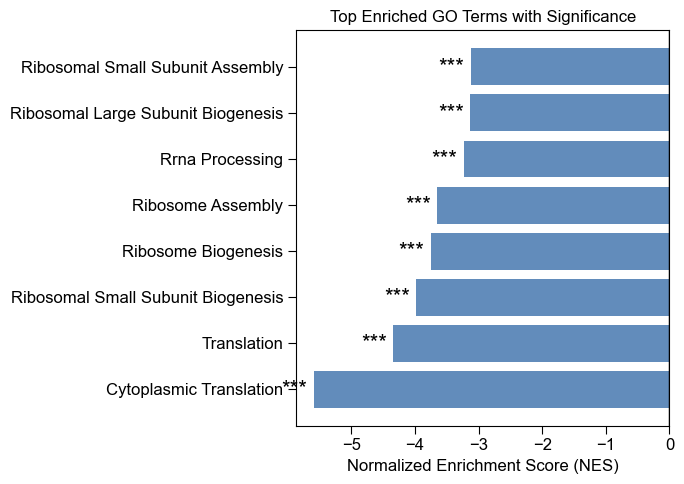

In [600]:
# Select top 10 results (adjust as needed)
plot_df = res_df.head(8).copy()

# Clean up the GO term names for display
plot_df['Term_short'] = (
    plot_df['Term']
      .str.replace('GOBP_', '', regex=False)
      .str.replace('_', ' ', regex=False)
      .str.title()
)

# Ensure FDR q-val is float
plot_df['FDR q-val'] = pd.to_numeric(plot_df['FDR q-val'], errors='coerce').fillna(1.0)

# Calculate color values from FDR q-value
fdr_log = -np.log10(plot_df['FDR q-val'] + 1e-8)

# Assign stars based on FDR q-value
def pval_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

plot_df['stars'] = plot_df['FDR q-val'].apply(pval_to_star)

plt.figure(figsize=(7, 5))
bars = plt.barh(
    plot_df['Term_short'],
    plot_df['NES'],
    color='#628CBB'
)
plt.xlabel('Normalized Enrichment Score (NES)')
plt.title('Top Enriched GO Terms with Significance')
plt.axvline(0, color='black', linewidth=1)

# Add stars labels on bars
for bar, star in zip(bars, plot_df['stars']):
    width = bar.get_width()
    plt.text(
        width - 0.1 if width < 0 else width + 0.1,
        bar.get_y() + bar.get_height()/2,
        star,
        va='center',
        ha='right' if width < 0 else 'left',
        fontsize=16,
        color='black'
    )

plt.tight_layout()
plt.savefig(save_dir + "gsea_bar_plot_cd8_CD45_LEL_GO.svg", format="svg", bbox_inches='tight', pad_inches=0)

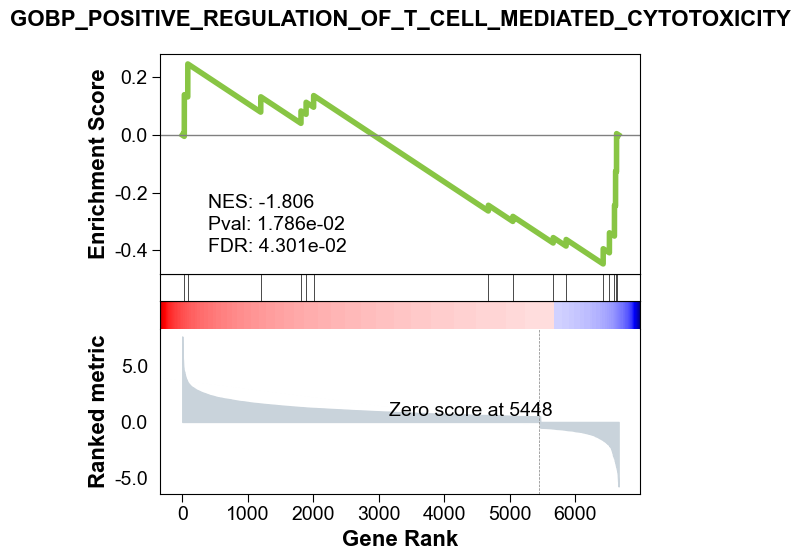

In [554]:
from gseapy.plot import gseaplot

term = "GOBP_POSITIVE_REGULATION_OF_T_CELL_MEDIATED_CYTOTOXICITY"
gseaplot(
    rank_metric=pre_res.ranking,
    term=term,
    **pre_res.results[term]
)
plt.savefig(save_dir + "gsea_plot_cd8_CD45_LEL_1.svg", format="svg", bbox_inches='tight', pad_inches=0)

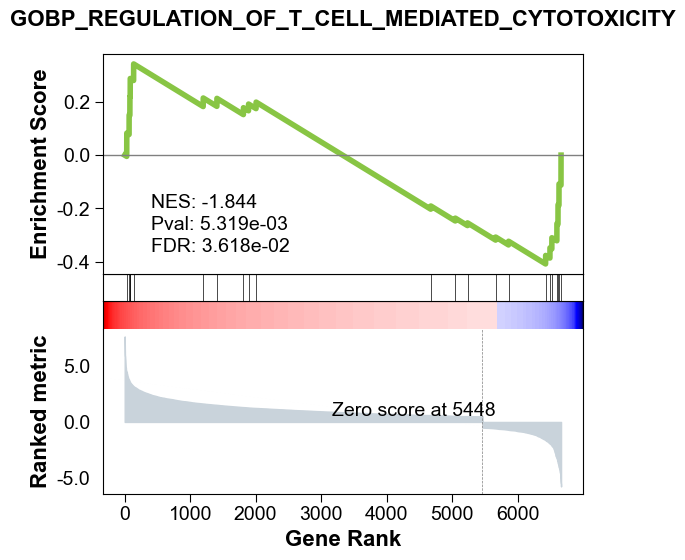

In [555]:
from gseapy.plot import gseaplot

term = "GOBP_REGULATION_OF_T_CELL_MEDIATED_CYTOTOXICITY"
gseaplot(
    rank_metric=pre_res.ranking,
    term=term,
    **pre_res.results[term]
)
plt.savefig(save_dir + "gsea_plot_cd8_CD45_LEL_2.svg", format="svg", bbox_inches='tight', pad_inches=0)

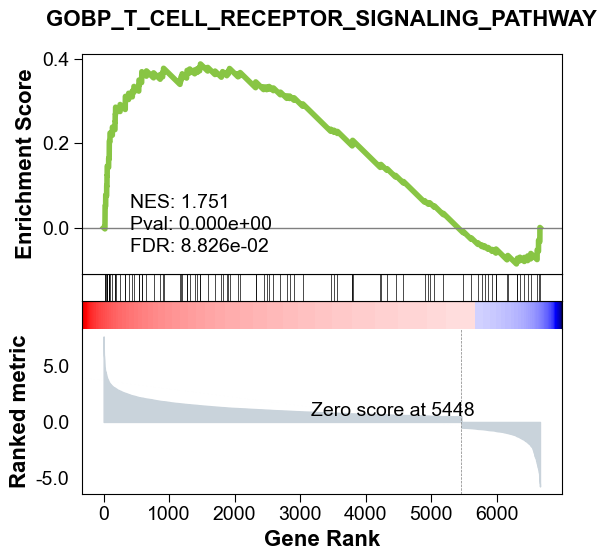

In [556]:
term = "GOBP_T_CELL_RECEPTOR_SIGNALING_PATHWAY"
gseaplot(
    rank_metric=pre_res.ranking,
    term=term,
    **pre_res.results[term]
)
plt.savefig(save_dir + "gsea_plot_cd8_CD45_LEL_3.svg", format="svg", bbox_inches='tight', pad_inches=0)

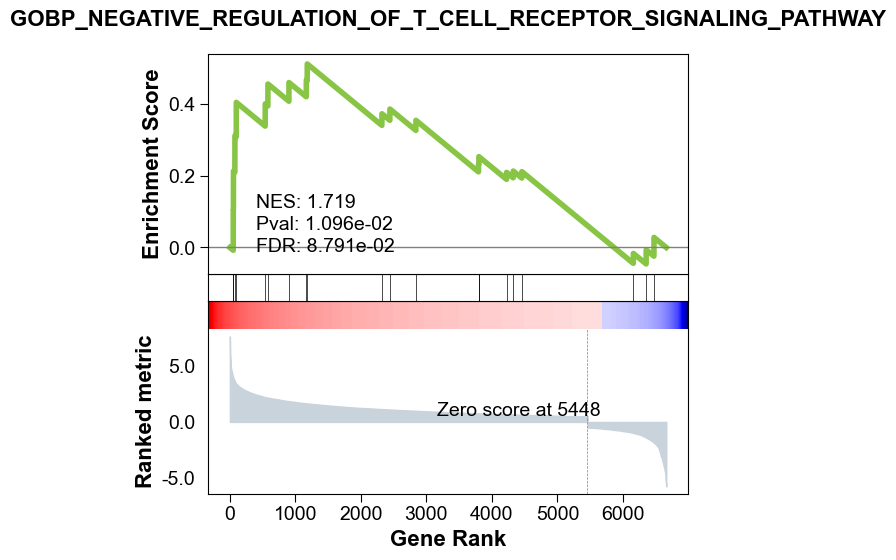

In [557]:
term = "GOBP_NEGATIVE_REGULATION_OF_T_CELL_RECEPTOR_SIGNALING_PATHWAY"
gseaplot(
    rank_metric=pre_res.ranking,
    term=term,
    **pre_res.results[term]
)
plt.savefig(save_dir + "gsea_plot_cd8_CD45_LEL_4.svg", format="svg", bbox_inches='tight', pad_inches=0)

In [530]:
# Filter with common apoptosis-related keywords
apoptosis_terms = res_df[res_df["Term"].str.contains("T_cell", case=False)]

In [531]:
apoptosis_terms.head(10)

Name                                               Term        ES  \
14   prerank                       GOBP_THYMIC_T_CELL_SELECTION  0.755737   
18   prerank                              GOBP_T_CELL_SELECTION  0.598614   
25   prerank                     GOBP_POSITIVE_T_CELL_SELECTION  0.593365   
73   prerank    GOBP_REGULATION_OF_T_CELL_MEDIATED_CYTOTOXICITY -0.408074   
91   prerank  GOBP_POSITIVE_REGULATION_OF_T_CELL_MEDIATED_CY... -0.448231   
126  prerank             GOBP_T_CELL_RECEPTOR_SIGNALING_PATHWAY  0.387655   
163  prerank  GOBP_NEGATIVE_REGULATION_OF_T_CELL_RECEPTOR_SI...  0.512362   
236  prerank                     GOBP_T_CELL_LINEAGE_COMMITMENT   0.50022   
275  prerank  GOBP_REGULATION_OF_T_CELL_RECEPTOR_SIGNALING_P...  0.426689   
294  prerank  GOBP_CD4_POSITIVE_OR_CD8_POSITIVE_ALPHA_BETA_T...  0.504413   

          NES NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
14   2.377314       0.0       0.0        0.0  10/16  10.96%   
18   2.281678       0.0  0.001321      0.005  15/35  10.96%   
25   2.175493       0.0  0.004932      0.026  13/30  10.96%   
73   -1.84368  0.005319  0.036178      0.696   7/22   3.56%   
91  -1.806148  0.017857  0.043008      0.769   5/15   3.56%   
126  1.750661       0.0  0.088261      0.993  39/95  22.20%   
163  1.718879  0.010962  0.087911      0.998   9/20  17.74%   
236  1.656146    0.0199  0.102296      0.999   7/20  11.93%   
275  1.632704  0.011429  0.105969        1.0  15/35  19.14%   
294  1.620955  0.021438  0.109115        1.0   6/18  10.96%   

                                            Lead_genes  
14   TOX;NFATC3;PTPRC;CD74;CARD11;DOCK2;CD3G;PTPN2;...  
18   TOX;NFATC3;PTPRC;SLAMF6;SYK;OPA1;CD74;CARD11;E...  
25   TOX;NFATC3;PTPRC;SLAMF6;OPA1;CD74;EP300;DOCK2;...  
73              IL7R;HLA-E;B2M;HLA-B;HLA-A;KLRC1;HLA-C  
91                         HLA-E;B2M;HLA-B;HLA-A;HLA-C  
126  PLCG2;FYB1;PTPRC;TRGC2;CBLB;SLA2;PTPN22;INPP5D...  
163    CBLB;SLA2;PTPN22;NCK1;PTPN2;PHPT1;DGKZ;ELF1;EZR  
236                TOX;SLAMF6;OPA1;EP300;JAK3;SPN;TP53  
275  PTPRC;CBLB;SLA2;PTPN22;NCK1;UBR2;CARD11;PTPN2;...  
294                     TOX;SLAMF6;OPA1;EP300;JAK3;SPN

In [611]:
from matplotlib.ticker import LogFormatterSciNotation
from matplotlib.colors import LogNorm

# Function to create bar plot for GO results
def create_bubble_plot(go_results_df, title):
    # Sorting the data by p-value and selecting the top 20 terms for visualization
    go_results_df = go_results_df.sort_values('p_value').head(20)
    go_results_df['GeneRatio'] = go_results_df['intersection_size']/go_results_df['term_size']
    go_results_df['p_value'] = go_results_df['p_value'].apply(lambda x: f"{x:.2e}")

    # Create a bubble plot
    plt.figure(figsize=(12, 8))
    bubble_plot = sns.scatterplot(
        x='GeneRatio',  # Use 'GeneRatio' for the x-axis
        y='name',  # GO terms on the y-axis
        size='intersection_size',  # Size of the bubbles (intersection size or count)
        hue='p_value',  # Color based on p-value
        data=go_results_df,
        sizes=(100, 1000),  # Bubble size range
        palette='coolwarm_r',  # Color palette for p-value
        edgecolor='black',
        norm=LogNorm()  # Apply logarithmic normalization to p-value colors
    )

    # Set title and axis labels
    bubble_plot.set_title(title, fontsize=16)
    bubble_plot.set_xlabel("GeneRatio", fontsize=12)
    bubble_plot.set_ylabel("GO Term", fontsize=12)
    
     # Adjust the colorbar to use scientific notation
    #norm = LogNorm(vmin=go_results_df['p_value'].min(), vmax=go_results_df['p_value'].max())
    #sm = plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm)
    #sm.set_array([])
    
    #cbar = plt.colorbar(sm)
    #cbar.set_label('p.adjust')
    #cbar.ax.yaxis.set_major_formatter(LogFormatterSciNotation()) 

    # Adjust layout for better display
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Adjust legend placement to a more suitable location
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=10, markerscale=0.5)
    
    # Display the plot
    plt.show()

# Example usage with the GO results DataFrame
#create_bubble_plot(go_results_upregulated_1h, "GO Enrichment Bubble Plot (Upregulated Genes in 1h)")

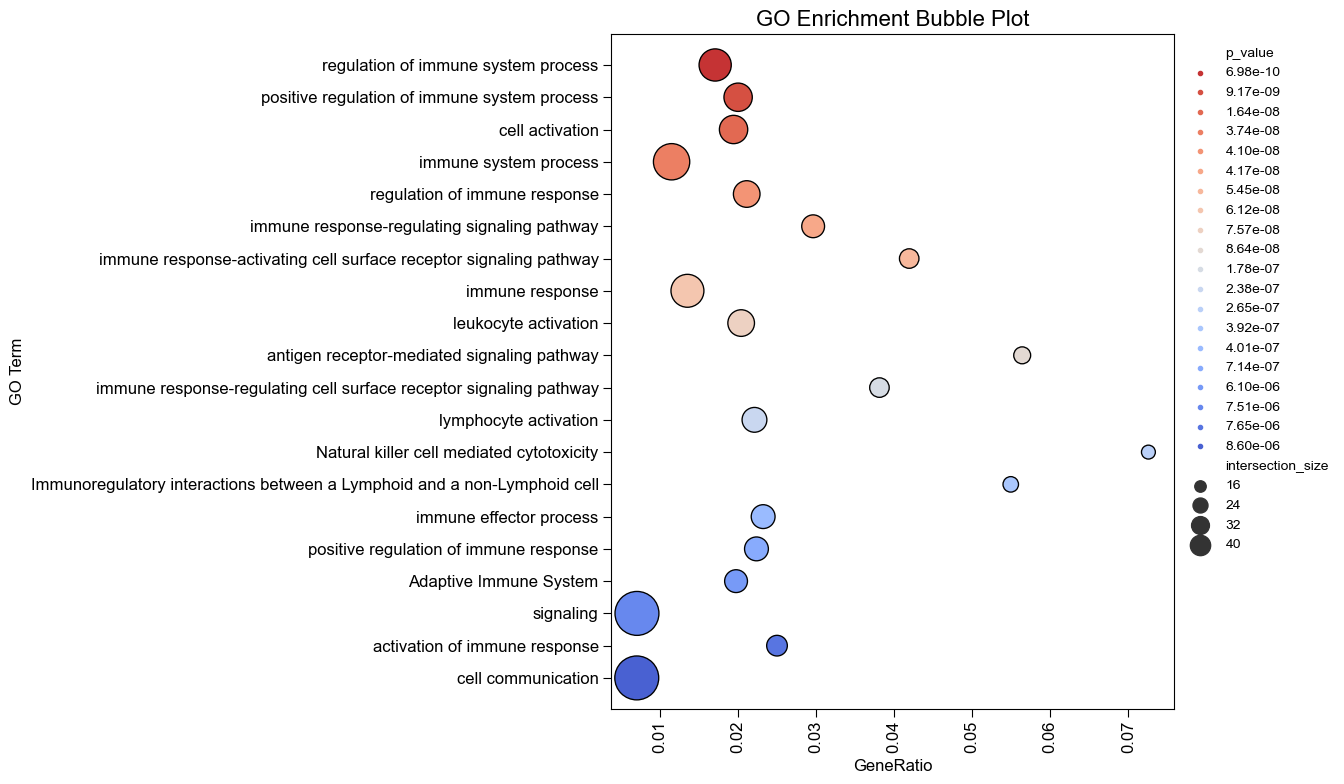

In [615]:
#upregulated_high = markers_high['Gene'].unique().tolist()
upregulated_high = markers_high['Gene'].unique().tolist()

# Initialize GProfiler for GO analysis
gp = GProfiler(return_dataframe=True)

# Perform GO analysis for upregulated genes in Cluster 0
go_results = gp.profile(organism='hsapiens', query=upregulated_high)
create_bubble_plot(go_results, "GO Enrichment Bubble Plot")

CD8 T cells differentiation; from naive to tcm to tem to tem ra

In [76]:
# 4. Subset to CD8 Naive, Tcm, Tem
cd8_subtypes = ["CD8+ Naive T cells", "CD8+ Central Memory", "CD8+ Effector Memory", "CD8+ Effector Memory RA"]
adata_cd8 = adata[adata.obs['manual_annotation'].isin(cd8_subtypes)].copy()

In [77]:
# Load pseudotime values from CSV
cd8_pt_df = pd.read_csv("GPS/20250521/cd8_monocle3_PT.csv")  # contains 'cell_id' and 'pseudotime'

# Set index to match adata.obs_names
cd8_pt_df.index = cd8_pt_df['cell']

# Assign pseudotime
adata_cd8.obs['pseudotime'] = cd8_pt_df.loc[:,'pseudotime']

In [78]:
# Create a boolean mask for inf, -inf, or NaN values in pseudotime
inf_or_nan_mask = np.isinf(adata_cd8.obs['pseudotime']) | np.isnan(adata_cd8.obs['pseudotime'])
# Filter out those rows
adata_cd8 = adata_cd8[~inf_or_nan_mask].copy()

In [79]:
#process data
adata_cd8.layers["counts"] = adata_cd8.X.copy() # preserve counts
sc.pp.normalize_total(adata_cd8)
sc.pp.log1p(adata_cd8)
adata_cd8.raw = adata_cd8.copy() # freeze the state in `.raw`
sc.pp.highly_variable_genes(adata_cd8, n_top_genes=4000)
adata_cd8 = adata_cd8[:, adata_cd8.var['highly_variable']]
sc.pp.scale(adata_cd8, max_value=10)
sc.tl.pca(adata_cd8, svd_solver='arpack')

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [80]:
sc.pp.neighbors(adata_cd8, n_neighbors=10, n_pcs=20)

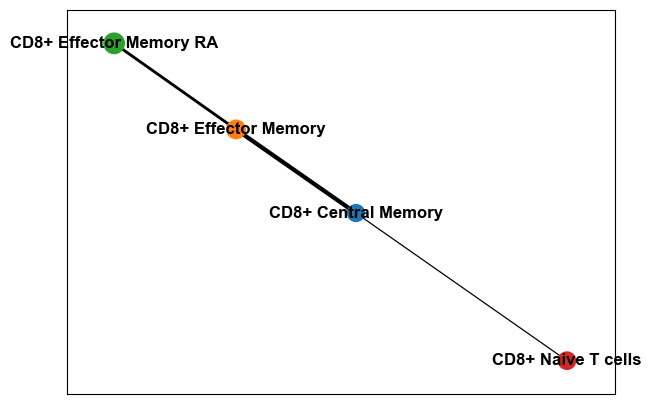

In [81]:
sc.tl.paga(adata_cd8, groups="manual_annotation")
sc.pl.paga(adata_cd8, color=["manual_annotation"])

In [82]:
# Select a root cell from the earliest time point
early_cells = adata_cd8.obs[adata_cd8.obs["manual_annotation"] == "CD8+ Naive T cells"].index  # Adjust based on actual time point labels
adata_cd8.uns["iroot"] = adata_cd8.obs.index.get_loc(early_cells[0])  # Set root cell index

# Run DPT with root cell
sc.tl.dpt(adata_cd8)

In [83]:
# Define new desired order (swapping Naive and Central Memory)
new_order = ['CD8+ Naive T cells', 'CD8+ Central Memory', 'CD8+ Effector Memory', 'CD8+ Effector Memory RA']

# Update category order
adata_cd8.obs["manual_annotation"] = pd.Categorical(
    adata_cd8.obs["manual_annotation"],
    categories=new_order,
    ordered=True
)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1229: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1276: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


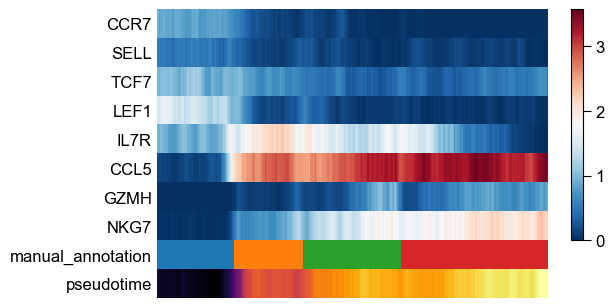

In [84]:
markers_gene = ["CCR7", "SELL", 'TCF7','LEF1',"IL7R",'CCL5','GZMH','NKG7']
plt.figure(figsize=(6.5, 3))
sc.pl.paga_path(
        adata_cd8,
        keys=markers_gene,
        nodes=['CD8+ Naive T cells','CD8+ Central Memory','CD8+ Effector Memory', 'CD8+ Effector Memory RA'],
        show_node_names=False,
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime"],
        show_colorbar=True,
        color_map="RdBu_r",
        groups_key="manual_annotation",
        color_maps_annotations={"pseudotime": "inferno"},
        return_data=False,
        show=False
    )
# Show plot
plt.show()

In [85]:
# Transpose so rows = cells, columns = lectins
ctrl_lectin_T = clr_ctrl_lectin.T
ctrl_protein_T = clr_ctrl_protein.T

# Ensure index matches adata_cd4.obs_names
cd8_common_cells = adata_cd8.obs_names.intersection(ctrl_lectin_T.index)

# Subset both
adata_cd8 = adata_cd8[cd8_common_cells].copy()
ctrl_lectin_T = ctrl_lectin_T.loc[cd8_common_cells]
ctrl_protein_T = ctrl_protein_T.loc[cd8_common_cells]

In [86]:
for lectin in ctrl_lectin_T.columns:
    new_key = f"LDT_{lectin}"
    # Add to .obs with the prefixed name
    adata_cd8.obs[new_key] = ctrl_lectin_T[lectin]

In [87]:
for protein in ctrl_protein_T.columns:
    new_key = f"ADT_{protein}"
    # Add to .obs with the prefixed name
    adata_cd8.obs[new_key] = ctrl_protein_T[protein]

In [88]:
#match cell index 
adata_pla_cd8 = sc.AnnData(clr_pla.T.loc[cd8_common_cells,:])
adata_pla_cd8.obs["celltype"] = adata_cd8.obs.loc[cd8_common_cells, "manual_annotation"]

In [90]:
# Extract CD45:LEL values by column name
cd45_lel_series = pd.Series(
    adata_pla_cd8[:, 'CD45:LEL'].X.flatten(),
    index=adata_pla_cd8.obs_names,
    name='CD45:LEL'
)

In [91]:
adata_cd8.obs['CD45:LEL'] = cd45_lel_series.loc[adata_cd8.obs_names]

In [92]:
# Extract CD45:LEL values by column name
cd45_mal_series = pd.Series(
    adata_pla_cd8[:, 'CD45:MAL-I'].X.flatten(),
    index=adata_pla_cd8.obs_names,
    name='CD45:MAL-I'
)
adata_cd8.obs['CD45:MAL-I'] = cd45_mal_series.loc[adata_cd8.obs_names]

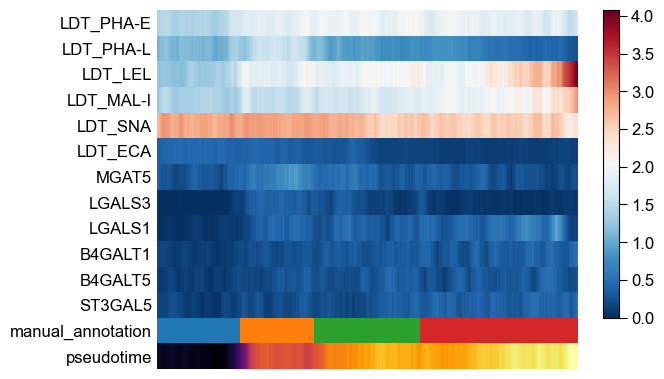

In [423]:
#lectin binding change alongside pseudotime
lectin = ["LDT_PHA-E", "LDT_PHA-L",'LDT_LEL', 'LDT_MAL-I', 'LDT_SNA','LDT_ECA',   
          'MGAT5','LGALS3','LGALS1','B4GALT1', 'B4GALT5', 'ST3GAL5']
plt.figure(figsize=(7, 4))
sc.pl.paga_path(
        adata_cd8,
        keys=lectin,
        nodes=['CD8+ Naive T cells','CD8+ Central Memory','CD8+ Effector Memory', 'CD8+ Effector Memory RA'],
        show_node_names=False,
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime"],
        show_colorbar=True,
        color_map="RdBu_r",
        groups_key="manual_annotation",
        color_maps_annotations={"pseudotime": "inferno"},
        return_data=False,
        show=False
    )
# Show plot
plt.savefig(save_dir + "cd8_ldt_trajectory_heatmap.svg", format='svg', bbox_inches='tight', pad_inches=0)

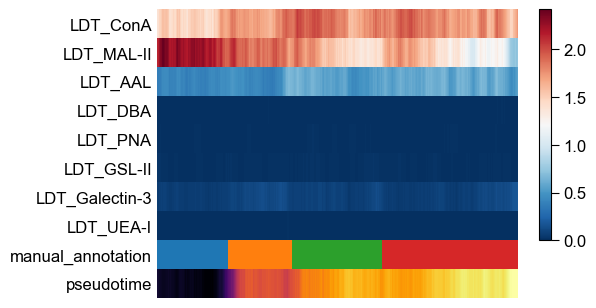

In [424]:
#lectin binding change alongside pseudotime
lectin = ['LDT_ConA', 'LDT_MAL-II', 'LDT_AAL','LDT_DBA','LDT_PNA', 'LDT_GSL-II', 'LDT_Galectin-3', 'LDT_UEA-I']
plt.figure(figsize=(6, 3))
sc.pl.paga_path(
        adata_cd8,
        keys=lectin,
        nodes=['CD8+ Naive T cells','CD8+ Central Memory','CD8+ Effector Memory', 'CD8+ Effector Memory RA'],
        show_node_names=False,
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime"],
        show_colorbar=True,
        color_map="RdBu_r",
        groups_key="manual_annotation",
        color_maps_annotations={"pseudotime": "inferno"},
        return_data=False,
        show=False
    )
# Show plot
plt.savefig(save_dir + "cd8_ldt_trajectory_heatmap_other.svg", format='svg', bbox_inches='tight', pad_inches=0)

In [116]:
#read adata_annotated 
adata_all = sc.read_h5ad('GPS/20250521/integrated_adata.h5ad')

In [117]:
#subset CD8 TEMRA
subset_mask = (
    (adata_all.obs['manual_annotation_reclustered'] == 'CD8+ Effector Memory RA') &
    (adata_all.obs['condition'] == 'control')
)

adata_cd8_temra_ctrl = adata_all[subset_mask].copy()

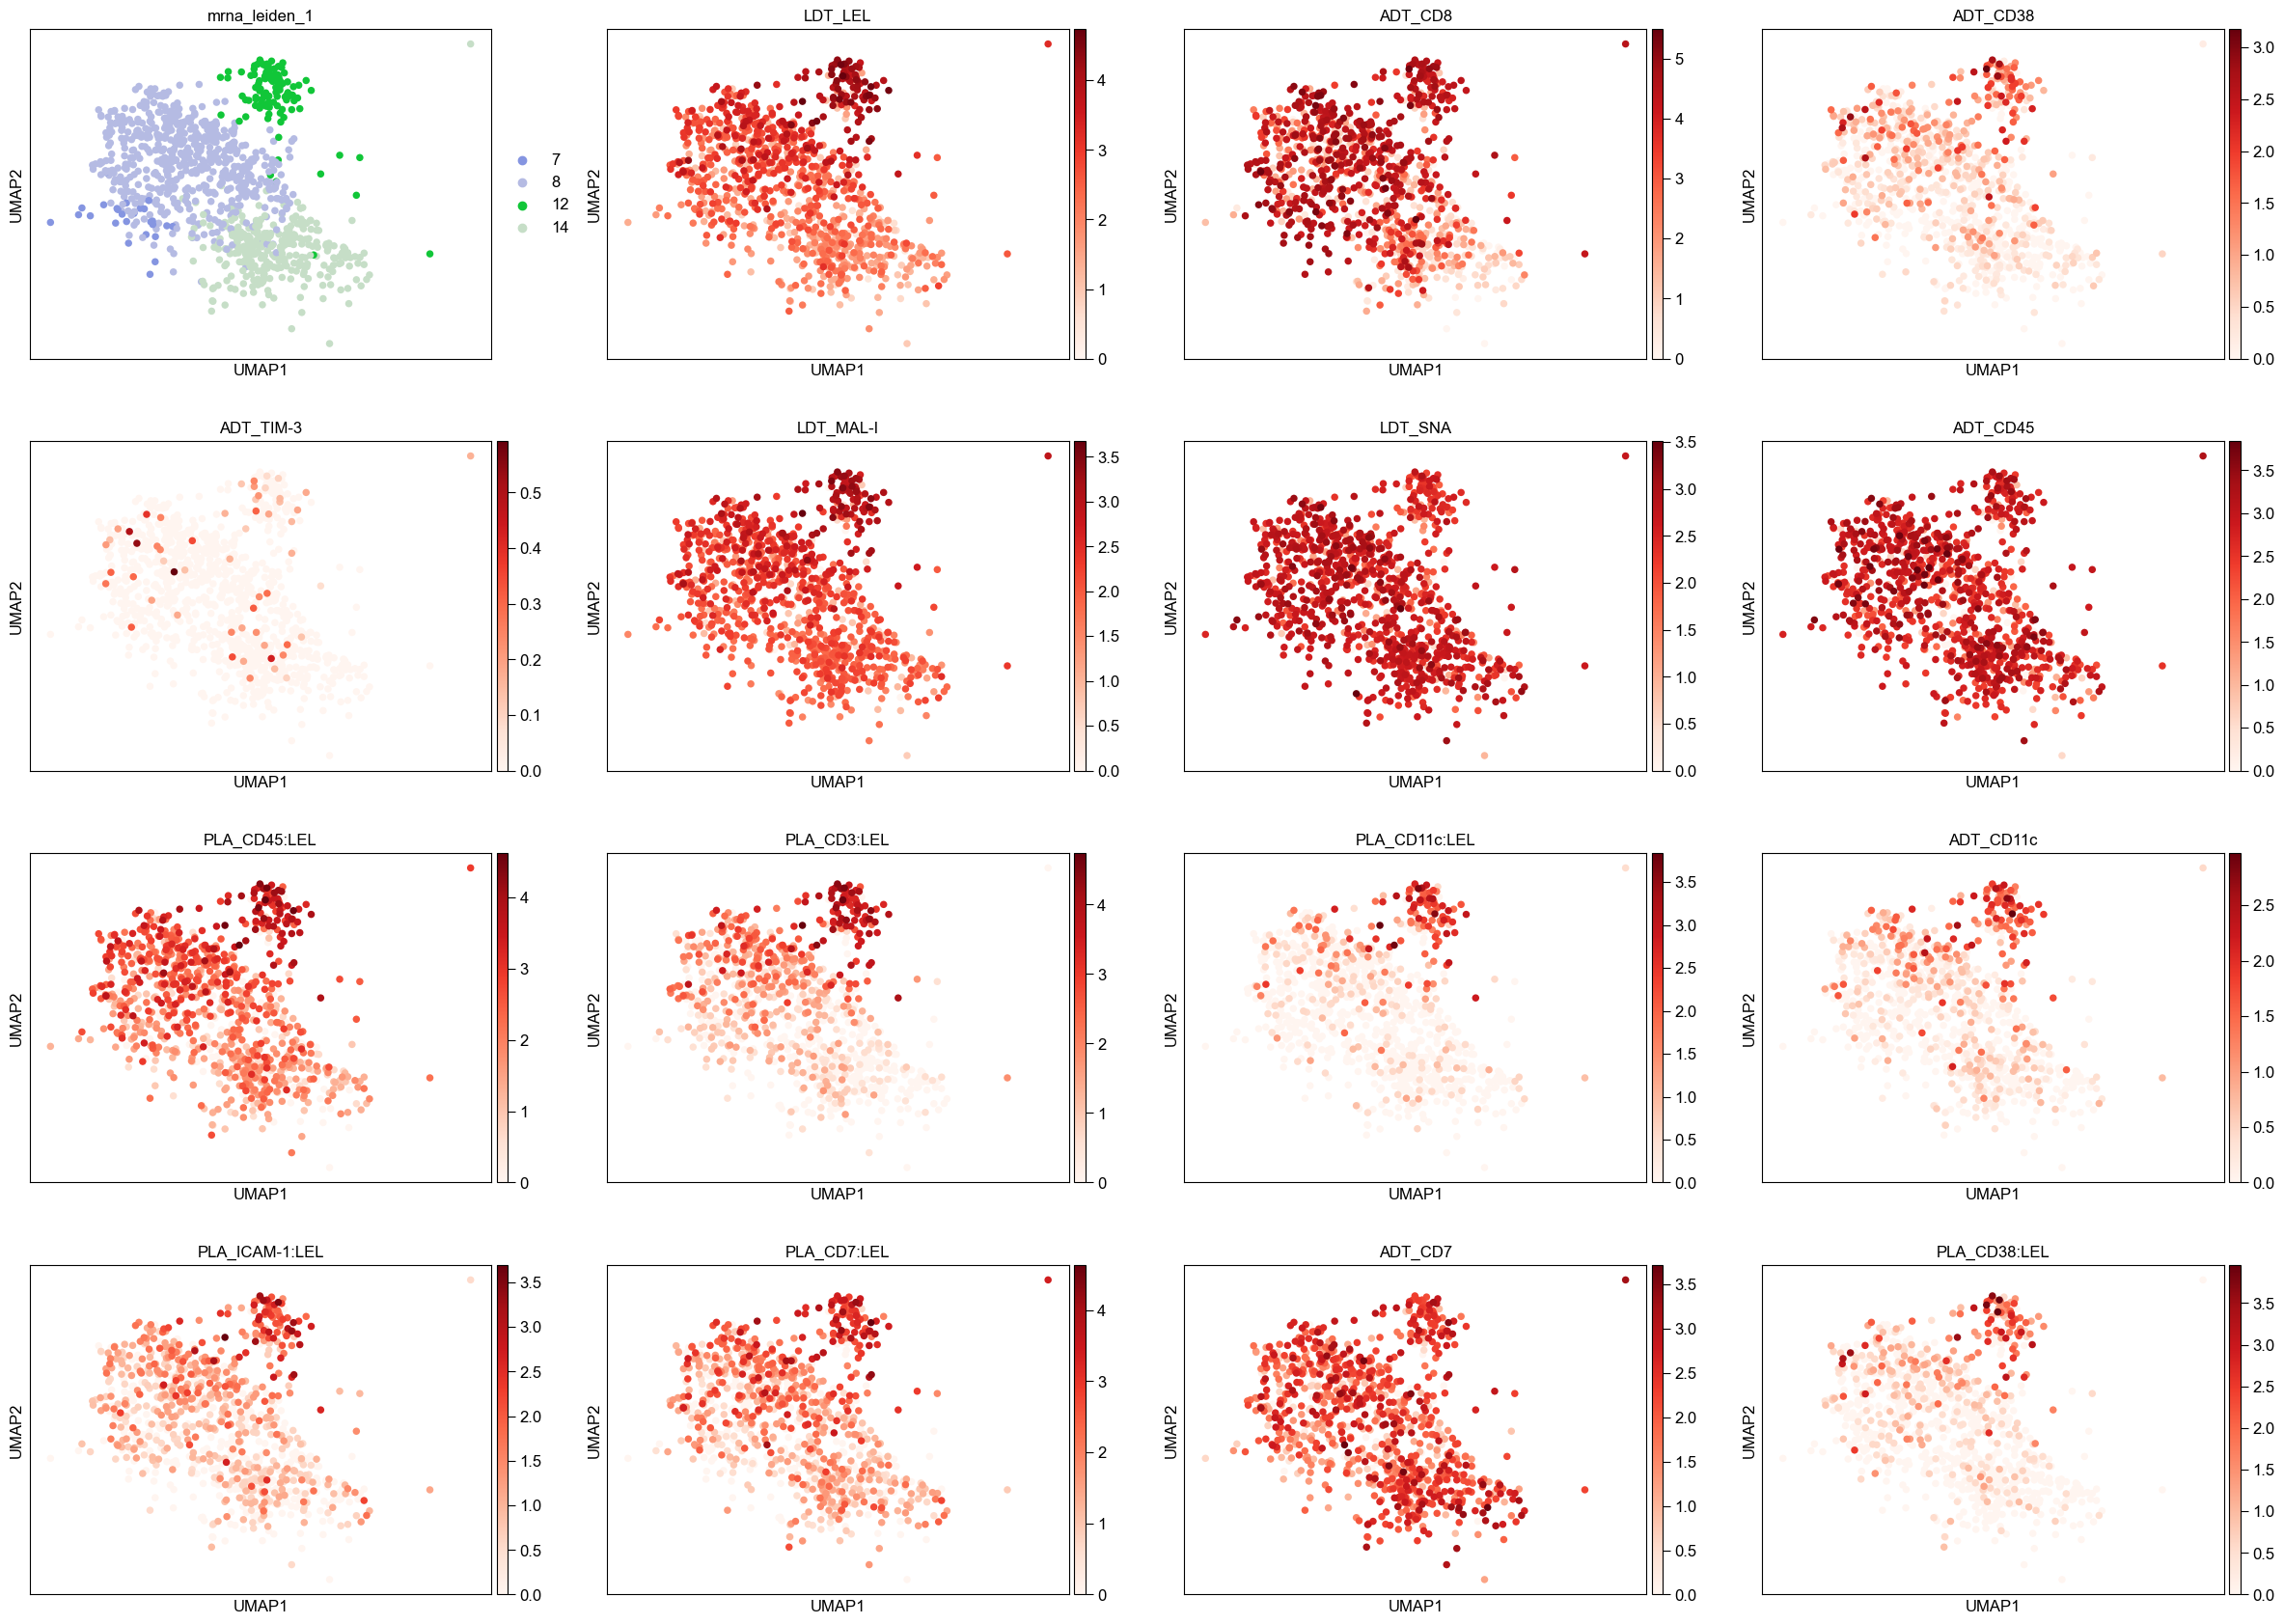

In [442]:
sc.pl.umap(adata_cd8_temra_ctrl, color=['mrna_leiden_1','LDT_LEL','ADT_CD8', 'ADT_CD38', 'ADT_TIM-3',
                                        'LDT_MAL-I', 'LDT_SNA','ADT_CD45','PLA_CD45:LEL','PLA_CD3:LEL', 'PLA_CD11c:LEL', 'ADT_CD11c', 'PLA_ICAM-1:LEL','PLA_CD7:LEL', 'ADT_CD7','PLA_CD38:LEL'], cmap='Reds')

In [139]:
# Step 3: Reclustering with Leiden
sc.tl.leiden(adata_cd8_temra_ctrl, resolution=0.1, key_added='leiden_sub')

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

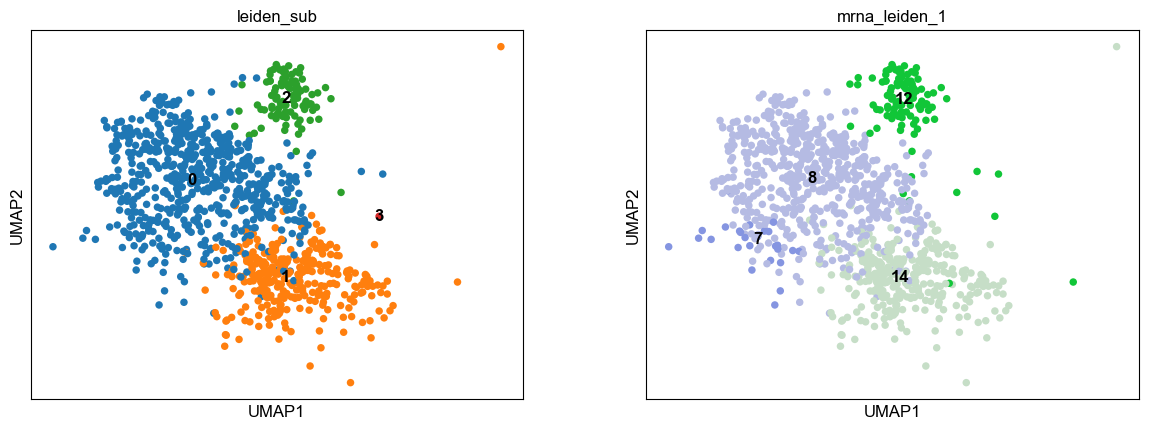

In [140]:
# Step 4: Plot UMAP with reclustered labels
sc.pl.umap(adata_cd8_temra_ctrl, color=['leiden_sub','mrna_leiden_1'], legend_loc='on data')

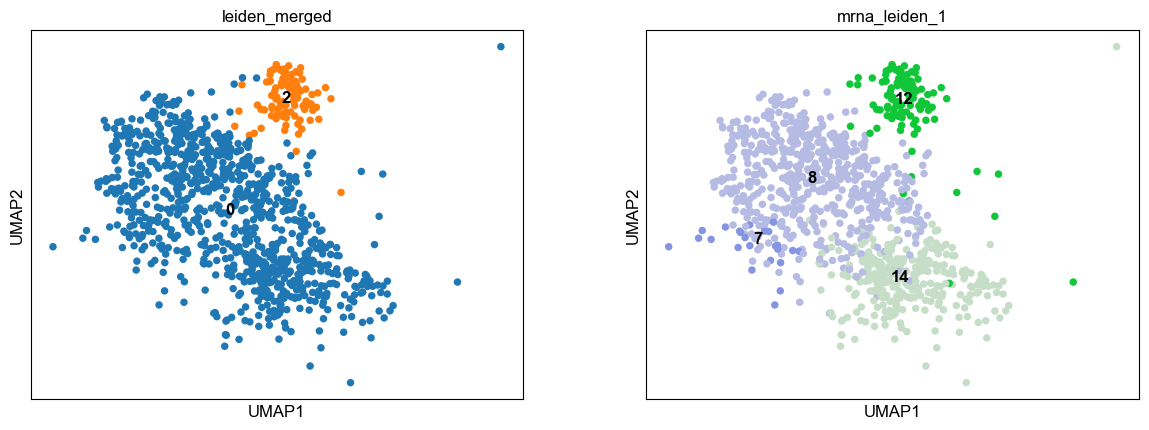

In [459]:
#merge 0,1,3
# Step 1: Copy the original clustering
adata_cd8_temra_ctrl.obs['leiden_merged'] = adata_cd8_temra_ctrl.obs['leiden_sub'].astype(str)

# Step 2: Merge clusters 0, 1, 3 into a single label (e.g., '0_1_3')
adata_cd8_temra_ctrl.obs['leiden_merged'] = adata_cd8_temra_ctrl.obs['leiden_merged'].replace(
    {'0': '0', '1': '0', '3': '0'}
)
# Step 3: Plot with the merged clustering
sc.pl.umap(adata_cd8_temra_ctrl, color=['leiden_merged', 'mrna_leiden_1'], legend_loc='on data')

In [567]:
# Set custom colors for leiden_merged clusters
adata_cd8_temra_ctrl.uns['leiden_merged_colors'] = ['#7DAEE0','#EA8379']

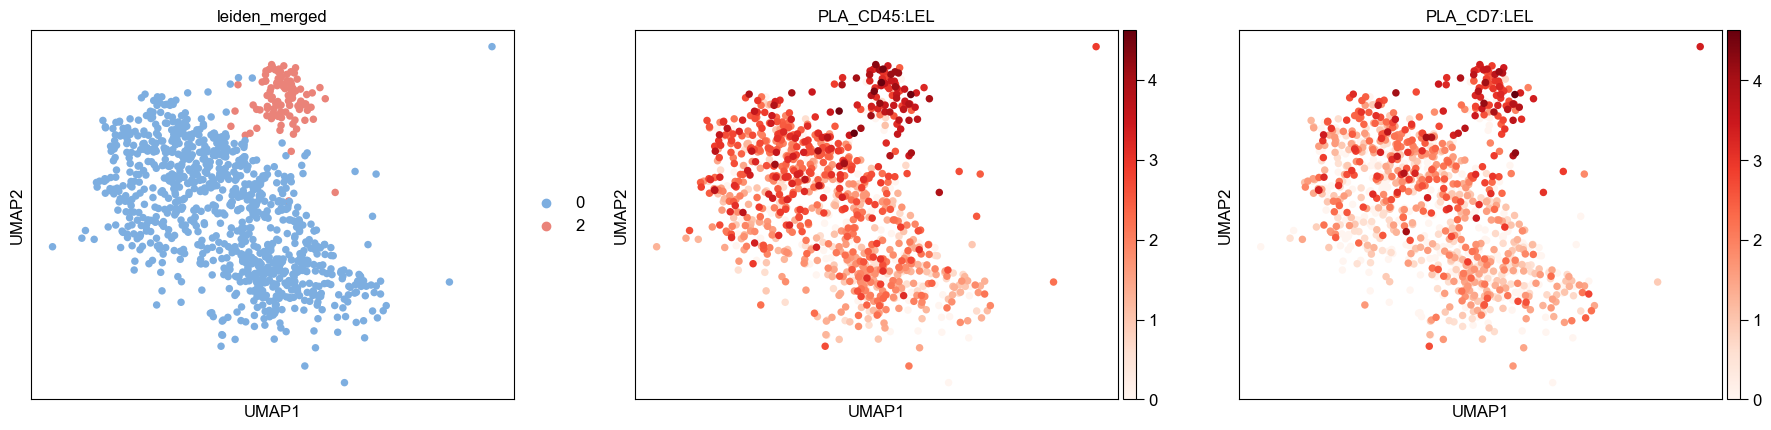

In [598]:
sc.pl.umap(adata_cd8_temra_ctrl, color=['leiden_merged', 'PLA_CD45:LEL', 'PLA_CD7:LEL'], cmap='Reds', show=False)
#plt.savefig(save_dir + "cd45_lel_subset_umap.svg", format='svg', bbox_inches='tight', pad_inches=0)

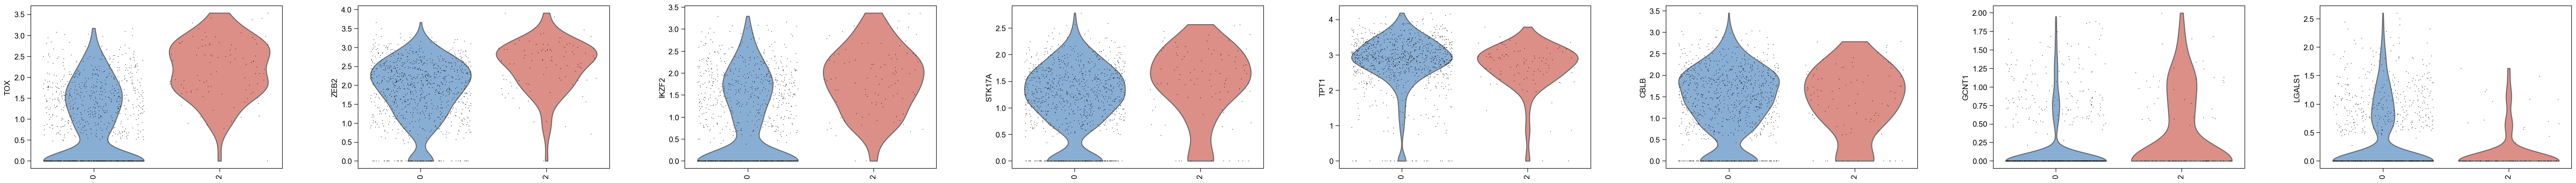

In [602]:
# Define exhaustion markers you want to check
exhaustion_genes = [
    'TOX',      # TOX TF
    'ZEB2',
    'IKZF2',
    'STK17A',
    'TPT1',
    'CBLB',
    'GCNT1',
    'LGALS1'
]

# Optional: make sure genes are present
#genes_present = [g for g in exhaustion_genes if g in adata_cd8_temra_ctrl.var_names]

# Violin plot
sc.pl.violin(
    adata_cd8_temra_ctrl,
    keys=exhaustion_genes,
    groupby='leiden_merged',  # Or another relevant grouping, e.g., 'leiden'
    stripplot=True,
    rotation=90,
    jitter=0.4,
    multi_panel=True
)


In [569]:
import scipy.sparse as sp

# Your genes of interest
exhaustion_genes = ['TOX', 'ZEB2', 'IKZF2','GCNT1']

# Get the gene indices in adata.raw.var_names (not adata.var_names!)
gene_indices = [adata_cd8_temra_ctrl.raw.var_names.get_loc(gene) for gene in exhaustion_genes]

# Extract expression data from raw.X
raw_X = adata_cd8_temra_ctrl.raw.X

# If sparse, convert to dense (only for selected columns for efficiency)
if sp.issparse(raw_X):
    expr_values = raw_X[:, gene_indices].toarray()
else:
    expr_values = raw_X[:, gene_indices]

# Build DataFrame
expr = pd.DataFrame(
    expr_values,
    columns=exhaustion_genes,
    index=adata_cd8_temra_ctrl.obs_names
)

# Add cluster/grouping info
expr['cluster'] = adata_cd8_temra_ctrl.obs['leiden_merged'].values

# Melt into long-format DataFrame for seaborn
df_melted = expr.melt(id_vars='cluster', var_name='Gene', value_name='Expression')


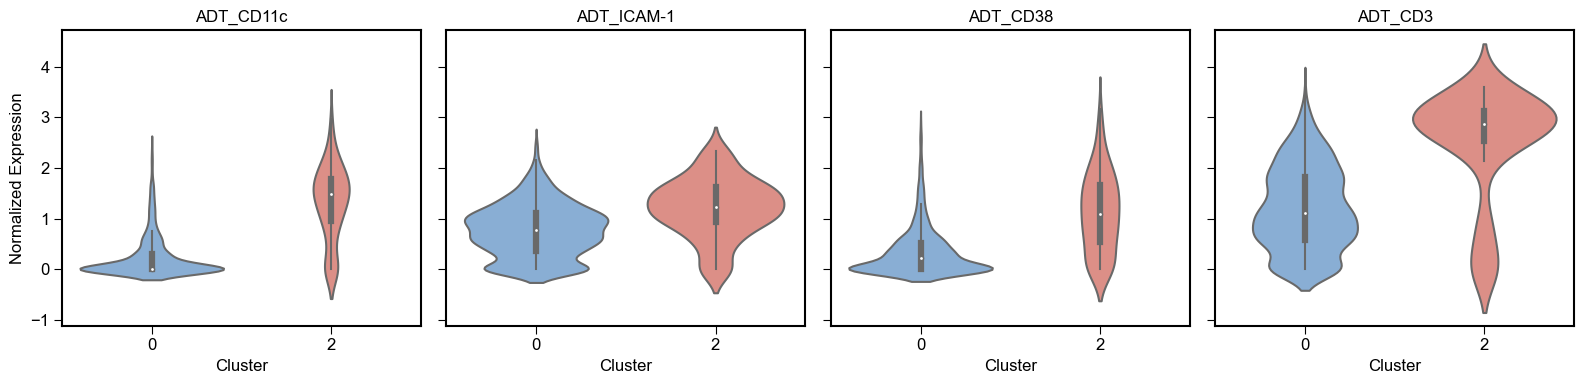

In [597]:
# Each gene in a separate subplot (facet)
g = sns.catplot(
    data=df_melted,
    x='cluster', y='Expression',  # or whatever your groupby variable is
    col='Gene',
    kind='violin',
    col_wrap=4,         # Number of plots per row, adjust as needed
    sharey=True,        # Set False if y scales should be independent
    height=4,           # Height per subplot
    palette= ['#7DAEE0','#EA8379']
)

# Add a frame to each subplot
for ax in g.axes.flatten():
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)  # You can adjust the width here
        spine.set_edgecolor('black')  # Or another color if you like
        
g.set_axis_labels("Cluster", "Normalized Expression")
g.set_titles("{col_name}")
plt.savefig(save_dir + "subset_adt_expression.svg", format='svg', bbox_inches='tight', pad_inches=0)

In [574]:
from scipy.stats import mannwhitneyu

# Get your unique cluster names (should be two)
clusters = sorted(df_melted['cluster'].unique())
assert len(clusters) == 2, "There should be exactly two clusters."

results = []

for gene in exhaustion_genes:
    vals1 = df_melted[(df_melted['Gene'] == gene) & (df_melted['cluster'] == clusters[0])]['Expression']
    vals2 = df_melted[(df_melted['Gene'] == gene) & (df_melted['cluster'] == clusters[1])]['Expression']
    # Mann–Whitney U test
    stat, pval = mannwhitneyu(vals1, vals2, alternative='two-sided')
    results.append({'Gene': gene, 'Cluster1': clusters[0], 'Cluster2': clusters[1], 'p-value': pval})

# Convert to DataFrame for nice display
import pandas as pd
mw_results = pd.DataFrame(results)
print(mw_results)

    Gene Cluster1 Cluster2       p-value
0    TOX        0        2  2.234909e-30
1   ZEB2        0        2  6.494464e-15
2  IKZF2        0        2  1.427285e-16
3  GCNT1        0        2  3.296831e-06


In [575]:
from statsmodels.stats.multitest import multipletests

# 'p-value' column from your mw_results DataFrame
mw_results['adj_pval'] = multipletests(mw_results['p-value'], method='fdr_bh')[1]
print(mw_results)

    Gene Cluster1 Cluster2       p-value      adj_pval
0    TOX        0        2  2.234909e-30  8.939636e-30
1   ZEB2        0        2  6.494464e-15  8.659285e-15
2  IKZF2        0        2  1.427285e-16  2.854569e-16
3  GCNT1        0        2  3.296831e-06  3.296831e-06


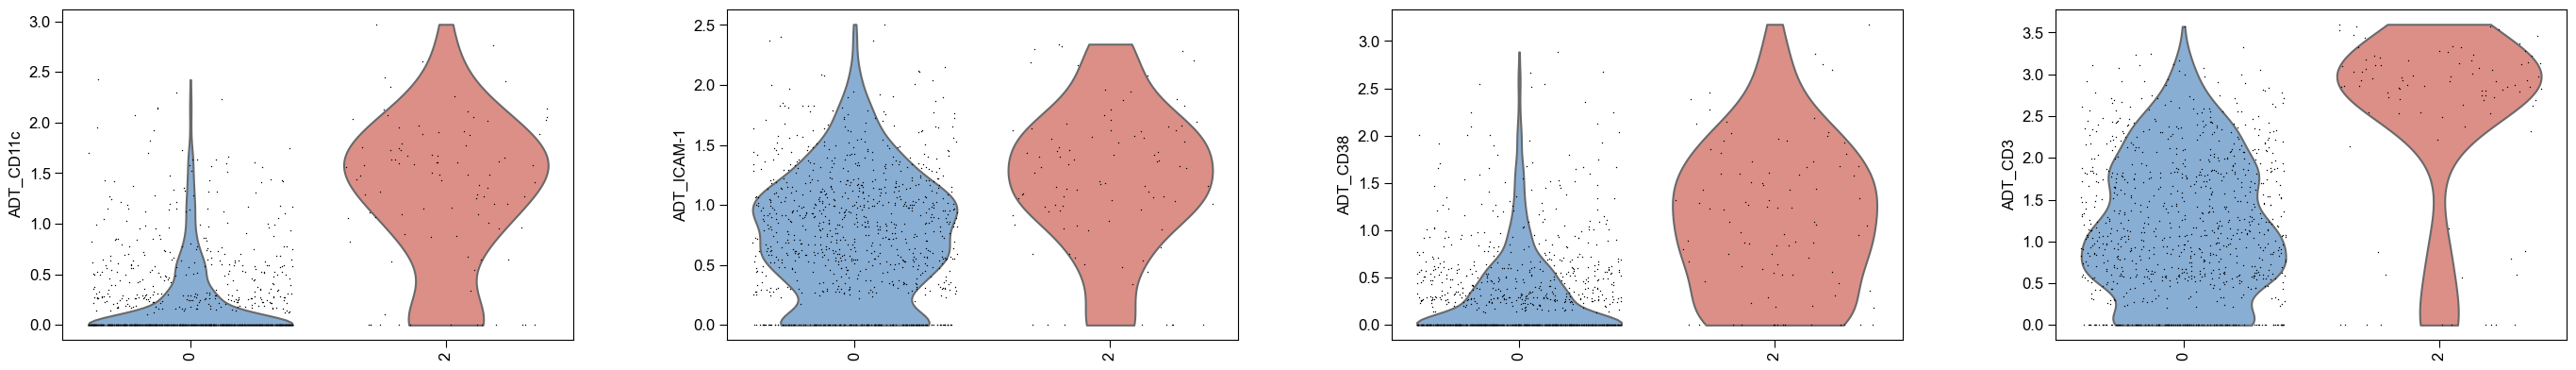

In [594]:
# Define exhaustion markers you want to check
exhaustion_genes = [
    'ADT_CD11c',
    'ADT_ICAM-1',
    'ADT_CD38',
    'ADT_CD3'
]

# Optional: make sure genes are present
#genes_present = [g for g in exhaustion_genes if g in adata_cd8_temra_ctrl.var_names]

# Violin plot
sc.pl.violin(
    adata_cd8_temra_ctrl,
    keys=exhaustion_genes,
    groupby='leiden_merged',  # Or another relevant grouping, e.g., 'leiden'
    stripplot=True,
    rotation=90,
    jitter=0.4,
    multi_panel=True
)


In [595]:
df_obs = adata_cd8_temra_ctrl.obs[exhaustion_genes]
# Add cluster/grouping info
df_obs['cluster'] = adata_cd8_temra_ctrl.obs['leiden_merged'].values

# Melt into long-format DataFrame for seaborn
df_melted = df_obs.melt(id_vars='cluster', var_name='Gene', value_name='Expression')

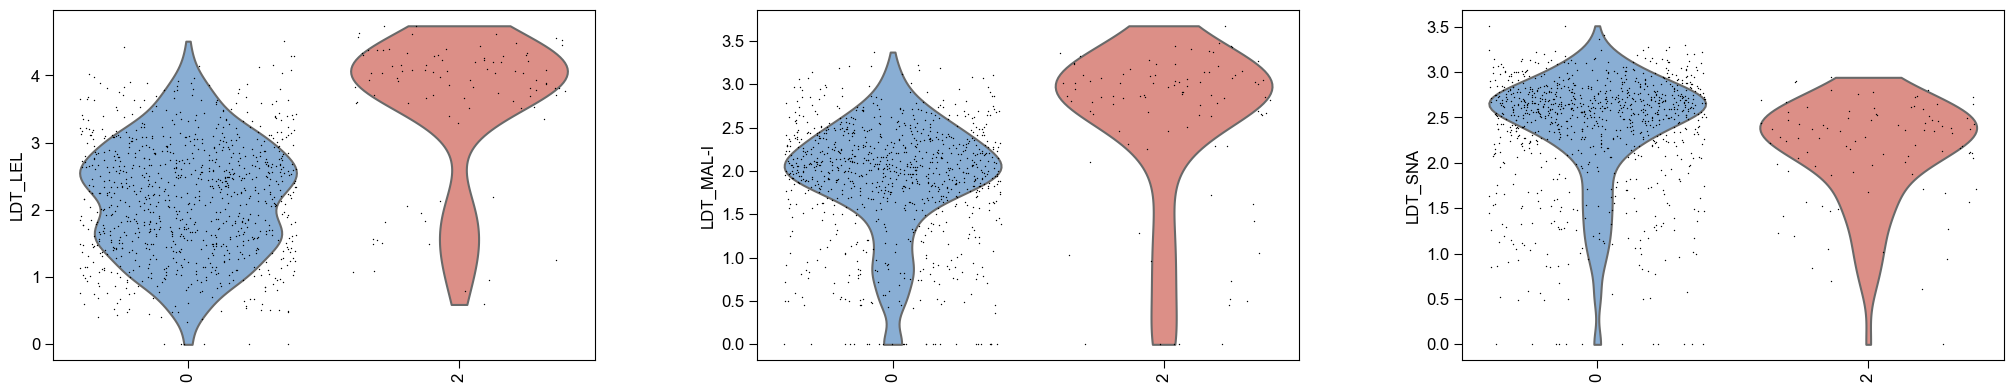

In [589]:
# Define exhaustion markers you want to check
exhaustion_genes = [
    'LDT_LEL',
    'LDT_MAL-I',
    'LDT_SNA'
]

# Optional: make sure genes are present
#genes_present = [g for g in exhaustion_genes if g in adata_cd8_temra_ctrl.var_names]

# Violin plot
sc.pl.violin(
    adata_cd8_temra_ctrl,
    keys=exhaustion_genes,
    groupby='leiden_merged',  # Or another relevant grouping, e.g., 'leiden'
    stripplot=True,
    rotation=90,
    jitter=0.4,
    multi_panel=True
)


In [149]:
sc.pp.normalize_total(adata_cd8_temra_ctrl, target_sum=1e4, layer='counts')
sc.pp.log1p(adata_cd8_temra_ctrl, layer='counts')

In [156]:
sc.tl.rank_genes_groups(
    adata_cd8_temra_ctrl,
    groupby="leiden_merged",
    method="wilcoxon",
    use_raw=False,
    layer="counts",  # make sure to use the correct layer
)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [608]:
#convert to dataframe
results = adata_cd8_temra_ctrl.uns['rank_genes_groups']
('0', '1', '2', '3', '4')

out = np.array([[0,0,0,0,0]])
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group])).astype('object'))).T))



markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])

#markers = markers[(markers.pval_adj < 0.05) & (markers.lfc > 0.5)]

In [618]:
markers_high

Gene     scores  pval_adj       lfc cluster
4000            CHSY3  14.906845       0.0  8.627867       2
4001              TOX  11.274068       0.0  2.918744       2
4002             AOAH   8.988908       0.0  1.269497       2
4003           ADGRG5   8.925266       0.0  2.878312       2
4004  ENSG00000273118   8.705937       0.0  2.627421       2
...               ...        ...       ...       ...     ...
4086             CTSC   3.206164  0.039564  0.847687       2
4087              LPP   3.166433  0.044092  0.834584       2
4088  ENSG00000291258   3.140005  0.047073  2.456687       2
4089           MAPRE2   3.120589  0.049691  0.882131       2
4090            ZNF80   3.119151  0.049691  2.641882       2

[91 rows x 5 columns]

In [617]:
markers_high = markers[(markers.cluster=='2') & (markers.pval_adj <= 0.05) & (markers.lfc >= 0.5)]

In [178]:
rnk = markers_high[["Gene", "scores"]].sort_values("scores", ascending=False)

# Write to rnk file
gsea_dir = "GPS/20250521/gsea_results/CD8_TEMRA_LEL"  # example path
lectin_name = "CD45:LEL"  # example name
os.makedirs(gsea_dir, exist_ok=True)
rnk_path = os.path.join(gsea_dir, f"{lectin_name}_ranked.rnk")
rnk.to_csv(rnk_path, sep="\t", index=False, header=False)

In [179]:
import gseapy as gp

pre_res = gp.prerank(
    rnk=rnk_path,
    gene_sets='GPS/20250521/gsea_results/c5.go.bp.v2025.1.Hs.symbols.gmt',
    outdir=gsea_dir,
    format='png',
    min_size=15,
    max_size=500,
    permutation_num=1000,
    seed=42,
    verbose=True,
)

# Process the result
res_df = pre_res.res2d.copy()
res_df.index = res_df.index.astype(str)

2025-08-04 11:32:11,614 [WARNING] Duplicated values found in preranked stats: 21.75% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-08-04 11:32:11,616 [INFO] Parsing data files for GSEA.............................
2025-08-04 11:32:11,766 [INFO] 6416 gene_sets have been filtered out when max_size=500 and min_size=15
2025-08-04 11:32:11,766 [INFO] 1167 gene_sets used for further statistical testing.....
2025-08-04 11:32:11,767 [INFO] Start to run GSEA...Might take a while..................
2025-08-04 11:32:15,539 [INFO] Congratulations. GSEApy runs successfully................



In [180]:
# Filter with common apoptosis-related keywords
T_cell_terms = res_df[res_df["Term"].str.contains("T_cell", case=False)]

In [181]:
T_cell_terms

Name                                               Term        ES  \
17    prerank                              GOBP_T_CELL_SELECTION  0.727342   
53    prerank                          GOBP_T_CELL_PROLIFERATION  0.567626   
97    prerank   GOBP_POSITIVE_REGULATION_OF_T_CELL_PROLIFERATION  0.598871   
116   prerank                              GOBP_T_CELL_MIGRATION  0.630608   
147   prerank             GOBP_T_CELL_RECEPTOR_SIGNALING_PATHWAY  0.541656   
183   prerank                             GOBP_T_CELL_ACTIVATION  0.430518   
239   prerank   GOBP_NEGATIVE_REGULATION_OF_T_CELL_PROLIFERATION  0.584882   
283   prerank               GOBP_REGULATION_OF_T_CELL_ACTIVATION  0.425881   
297   prerank                  GOBP_ALPHA_BETA_T_CELL_ACTIVATION  0.438307   
344   prerank                      GOBP_FAT_CELL_DIFFERENTIATION -0.394682   
369   prerank  GOBP_POSITIVE_REGULATION_OF_ALPHA_BETA_T_CELL_...  0.503397   
382   prerank                      GOBP_T_CELL_MEDIATED_IMMUNITY  0.457684   
398   prerank  GOBP_POSITIVE_REGULATION_OF_ALPHA_BETA_T_CELL_...  0.510149   
399   prerank                          GOBP_MAST_CELL_ACTIVATION  0.527102   
459   prerank  GOBP_T_CELL_DIFFERENTIATION_INVOLVED_IN_IMMUNE... -0.396821   
474   prerank             GOBP_ALPHA_BETA_T_CELL_DIFFERENTIATION  0.417439   
477   prerank                        GOBP_T_CELL_DIFFERENTIATION  0.385761   
535   prerank                  GOBP_T_CELL_MEDIATED_CYTOTOXICITY  0.501823   
690   prerank  GOBP_POSITIVE_REGULATION_OF_T_CELL_MEDIATED_IM...  0.443764   
695   prerank   GOBP_SUBSTRATE_ADHESION_DEPENDENT_CELL_SPREADING  0.439273   
735   prerank    GOBP_REGULATION_OF_ALPHA_BETA_T_CELL_ACTIVATION  0.381822   
748   prerank              GOBP_T_CELL_DIFFERENTIATION_IN_THYMUS  0.415644   
767   prerank     GOBP_CD4_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION  0.366871   
803   prerank        GOBP_REGULATION_OF_FAT_CELL_DIFFERENTIATION -0.345672   
822   prerank  GOBP_CD4_POSITIVE_ALPHA_BETA_T_CELL_DIFFERENTI...  0.366318   
826   prerank  GOBP_T_CELL_ACTIVATION_INVOLVED_IN_IMMUNE_RESP... -0.305549   
873   prerank  GOBP_REGULATION_OF_ALPHA_BETA_T_CELL_DIFFERENT...  0.362822   
926   prerank        GOBP_REGULATION_OF_T_CELL_MEDIATED_IMMUNITY -0.313958   
1046  prerank  GOBP_REGULATION_OF_CD4_POSITIVE_ALPHA_BETA_T_C... -0.285142   
1089  prerank  GOBP_REGULATION_OF_CD4_POSITIVE_ALPHA_BETA_T_C... -0.279476   
1127  prerank                    GOBP_T_CELL_CYTOKINE_PRODUCTION  0.306319   
1152  prerank  GOBP_POSITIVE_REGULATION_OF_CD4_POSITIVE_ALPHA... -0.235476   
1161  prerank   GOBP_CILIUM_OR_FLAGELLUM_DEPENDENT_CELL_MOTILITY  0.222687   

           NES NOM p-val FDR q-val FWER p-val   Tag %  Gene %  \
17    1.627685  0.007962  0.336786      0.895    5/16   4.17%   
53    1.514894  0.022222  0.427593      0.998   13/44  16.22%   
97     1.43537  0.063861  0.507843        1.0    6/23  13.02%   
116   1.414229  0.090639  0.499161        1.0    8/17  18.75%   
147   1.369211  0.072034  0.549453        1.0   11/32   6.71%   
183   1.329614  0.051995  0.577122        1.0  35/125  16.22%   
239   1.282794  0.182099  0.597649        1.0    7/15  25.19%   
283   1.245944  0.120359  0.616918        1.0   19/82  16.22%   
297   1.235068   0.15508   0.62602        1.0   10/58   5.42%   
344  -1.202393  0.177305       1.0        1.0    8/38   8.69%   
369   1.185144  0.262295  0.646178        1.0    6/21  18.56%   
382   1.173137  0.238976   0.66358        1.0   14/35  18.99%   
398   1.163355  0.290076  0.666958        1.0    5/18  18.56%   
399   1.163347  0.299383  0.665166        1.0    6/15  15.28%   
459  -1.137262   0.25256       1.0        1.0   10/32  14.15%   
474    1.12764  0.291609  0.662048        1.0    6/44   4.72%   
477    1.12707  0.258191  0.659208        1.0    9/74   4.72%   
535   1.094917  0.371473   0.68187        1.0   10/15  18.99%   
690   1.005617  0.473282  0.755026        1.0    7/18  18.99%   
695   1.002482  0.478462  0.756693        1.0    3/18   

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1229: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/plotting/_tools/paga.py:1276: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


<Axes: >

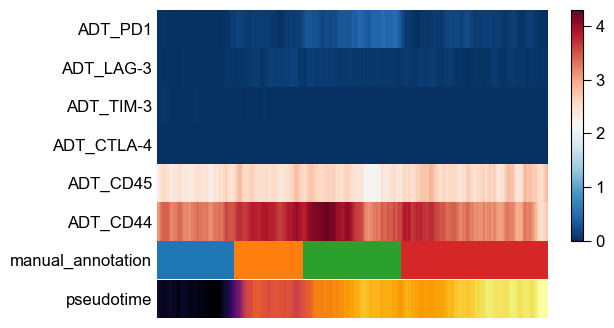

In [94]:
#lectin binding change alongside pseudotime
lectin = ['ADT_PD1', 'ADT_LAG-3', 'ADT_TIM-3','ADT_CTLA-4','ADT_CD45', 'ADT_CD44']
plt.figure(figsize=(6.5, 3))
sc.pl.paga_path(
        adata_cd8,
        keys=lectin,
        nodes=['CD8+ Naive T cells','CD8+ Central Memory','CD8+ Effector Memory', 'CD8+ Effector Memory RA'],
        show_node_names=False,
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=["pseudotime"],
        show_colorbar=True,
        color_map="RdBu_r",
        groups_key="manual_annotation",
        color_maps_annotations={"pseudotime": "inferno"},
        return_data=False,
        show=False
    )

In [425]:
# Filter cells
adata_sub = adata_cd8[adata_cd8.obs["manual_annotation"].isin(["CD8+ Naive T cells", "CD8+ Effector Memory RA"])].copy()

# Set group labels
adata_sub.obs["group"] = adata_sub.obs["manual_annotation"]

In [426]:
sc.tl.rank_genes_groups(
    adata_sub,
    groupby="group",
    groups=["CD8+ Effector Memory RA"],
    reference="CD8+ Naive T cells",
    method="wilcoxon",
    pts=True
)

de_result = sc.get.rank_genes_groups_df(adata_sub, group="CD8+ Effector Memory RA")
de_glyco = de_result[de_result["names"].isin(glyco_genes)].copy()

In [ ]:
de_glyco[de_glyco['significant'] == 'up'].sort_values('pvals_adj', ascending=True) 

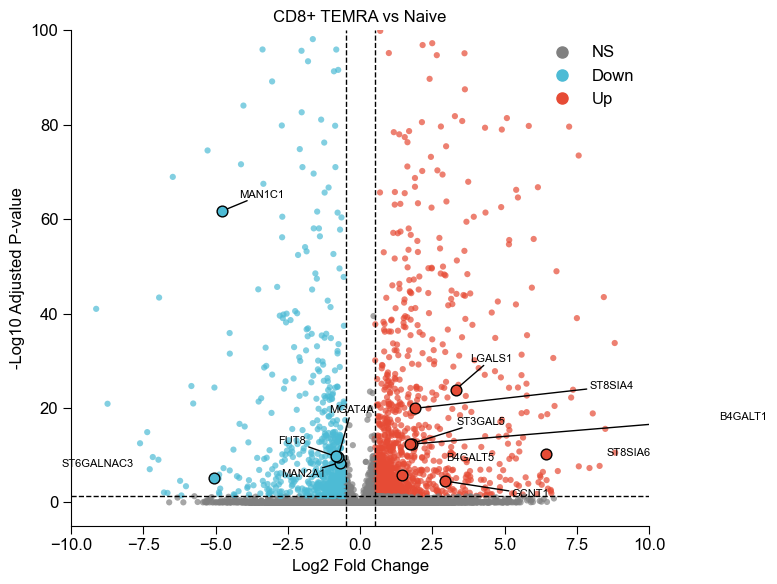

In [431]:
volcano_plot(
    de_result,
    label_genes=['LGALS1','B4GALT1', 'B4GALT5','ST8SIA4','ST3GAL5','ST8SIA6','GCNT1',
                 'MAN2A1','MAN1C1','ST6GALNAC3','MGAT4A','FUT8'],
    logfc_thresh=0.5,
    pval_thresh=0.05,
    title='CD8+ TEMRA vs Naive'
)

sns.despine()
plt.savefig(save_dir + "volcano_plot_CD8_TEMRA_Naive.svg", format='svg', bbox_inches='tight', pad_inches=0)

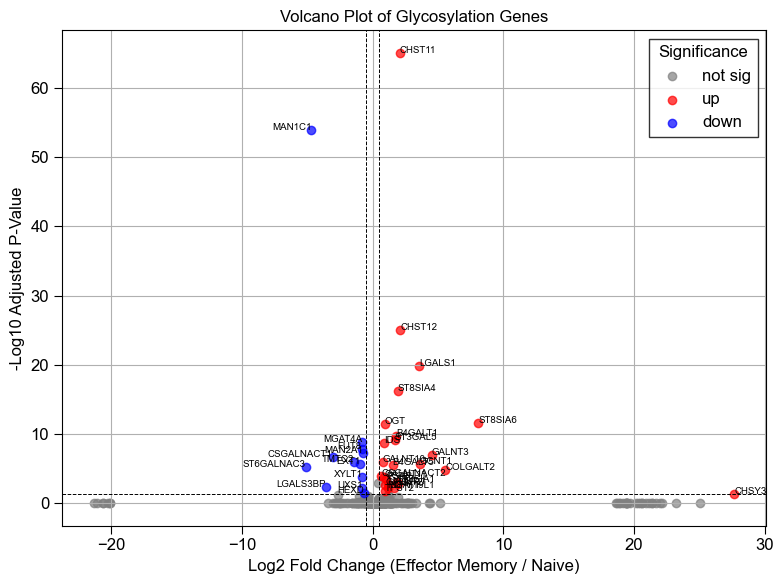

In [271]:
# Compute volcano plot axes
de_glyco["-log10(padj)"] = -np.log10(de_glyco["pvals_adj"] + 1e-300)

# Assign significance
de_glyco["significant"] = "not sig"
de_glyco.loc[(de_glyco["logfoldchanges"] > 0.5) & (de_glyco["pvals_adj"] < 0.05), "significant"] = "up"
de_glyco.loc[(de_glyco["logfoldchanges"] < -0.5) & (de_glyco["pvals_adj"] < 0.05), "significant"] = "down"

# Set color mapping
color_map = {
    "not sig": "gray",
    "up": "red",
    "down": "blue"
}

# Plot
plt.figure(figsize=(8, 6))
for sig in ["not sig", "up", "down"]:
    df = de_glyco[de_glyco["significant"] == sig]
    plt.scatter(df["logfoldchanges"], df["-log10(padj)"], c=color_map[sig], label=sig, alpha=0.7)

# Add labels to significantly changed glycosylation genes
for _, row in de_glyco.iterrows():
    if row["significant"] != "not sig":
        plt.text(
            row["logfoldchanges"], row["-log10(padj)"], row["names"],
            fontsize=7, ha='right' if row["logfoldchanges"] < 0 else 'left'
        )

# Threshold lines
plt.axhline(-np.log10(0.05), linestyle='--', color='black', linewidth=0.7)
plt.axvline(0.5, linestyle='--', color='black', linewidth=0.7)
plt.axvline(-0.5, linestyle='--', color='black', linewidth=0.7)

# Labels
plt.xlabel("Log2 Fold Change (Effector Memory / Naive)")
plt.ylabel("-Log10 Adjusted P-Value")
plt.title("Volcano Plot of Glycosylation Genes")
plt.grid(True)
plt.tight_layout()
plt.legend(title="Significance")
plt.show()


In [98]:
#match cell index 
adata_pla_cd8 = sc.AnnData(clr_pla.T.loc[cd8_common_cells,:])
adata_pla_cd8.obs["celltype"] = adata_cd8.obs.loc[cd8_common_cells, "manual_annotation"]

In [99]:
sc.pp.scale(adata_pla_cd8, max_value=10)

In [100]:
# Define new desired order (swapping Naive and Central Memory)
new_order = ['CD8+ Naive T cells', 'CD8+ Central Memory', 'CD8+ Effector Memory', 'CD8+ Effector Memory RA']

# Update category order
adata_pla_cd8.obs["celltype"] = pd.Categorical(
    adata_pla_cd8.obs["celltype"],
    categories=new_order,
    ordered=True
)

In [101]:
sc.tl.rank_genes_groups(
    adata_pla_cd8,
    groupby="celltype",
    method="wilcoxon",
)

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfold

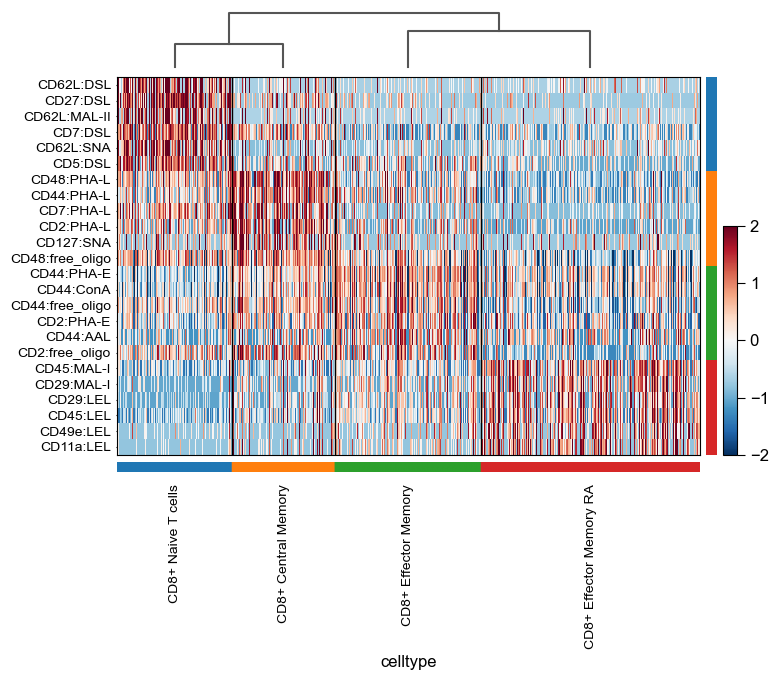

In [433]:
sc.pl.rank_genes_groups_heatmap(
    adata_pla_cd8,
    n_genes=6,
    cmap="RdBu_r",
    swap_axes=True,
    figsize=(8, 6),
    use_raw=False,
    vmax=2, vmin=-2,
    show=False
)
plt.savefig(save_dir+'CD8_PLA_heatmap.svg', format='svg', bbox_inches='tight', pad_inches=0)

In [201]:
test = extract_DEG_and_enrich_pathways(
    adata_weight=adata_pla_cd8,
    adata_rna=adata_cd8,
    marker='CD45:LEL',
    low_pct=10,
    high_pct=90
)

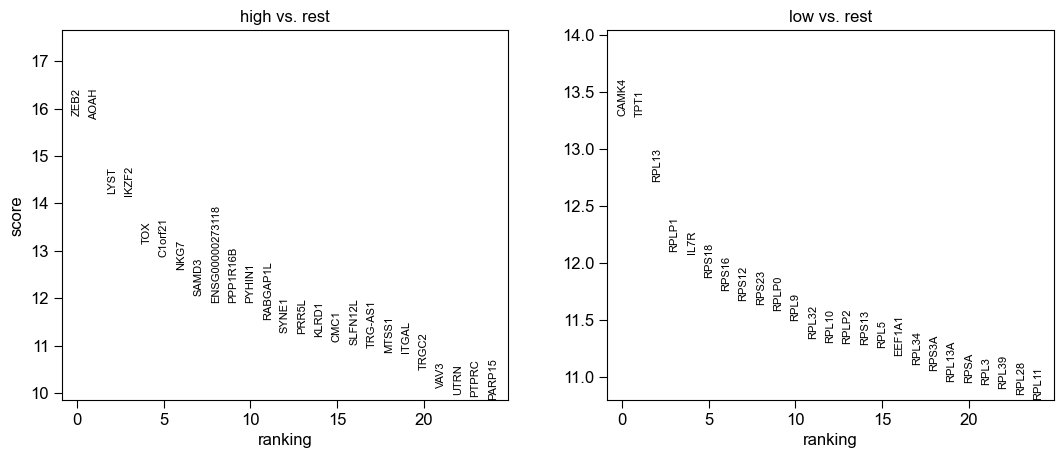

In [202]:
sc.tl.rank_genes_groups(test, groupby="group", method="wilcoxon")
sc.pl.rank_genes_groups(test, n_genes=25, sharey=False) 

In [203]:
#convert to dataframe
results = test.uns['rank_genes_groups']
('0', '1', '2', '3', '4')

out = np.array([[0,0,0,0,0]])
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group])).astype('object'))).T))



markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])

markers = markers[(markers.pval_adj < 0.05) & (markers.lfc > 1.5)]

/Users/junjie/anaconda3/envs/scanpy_Prox-seq/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


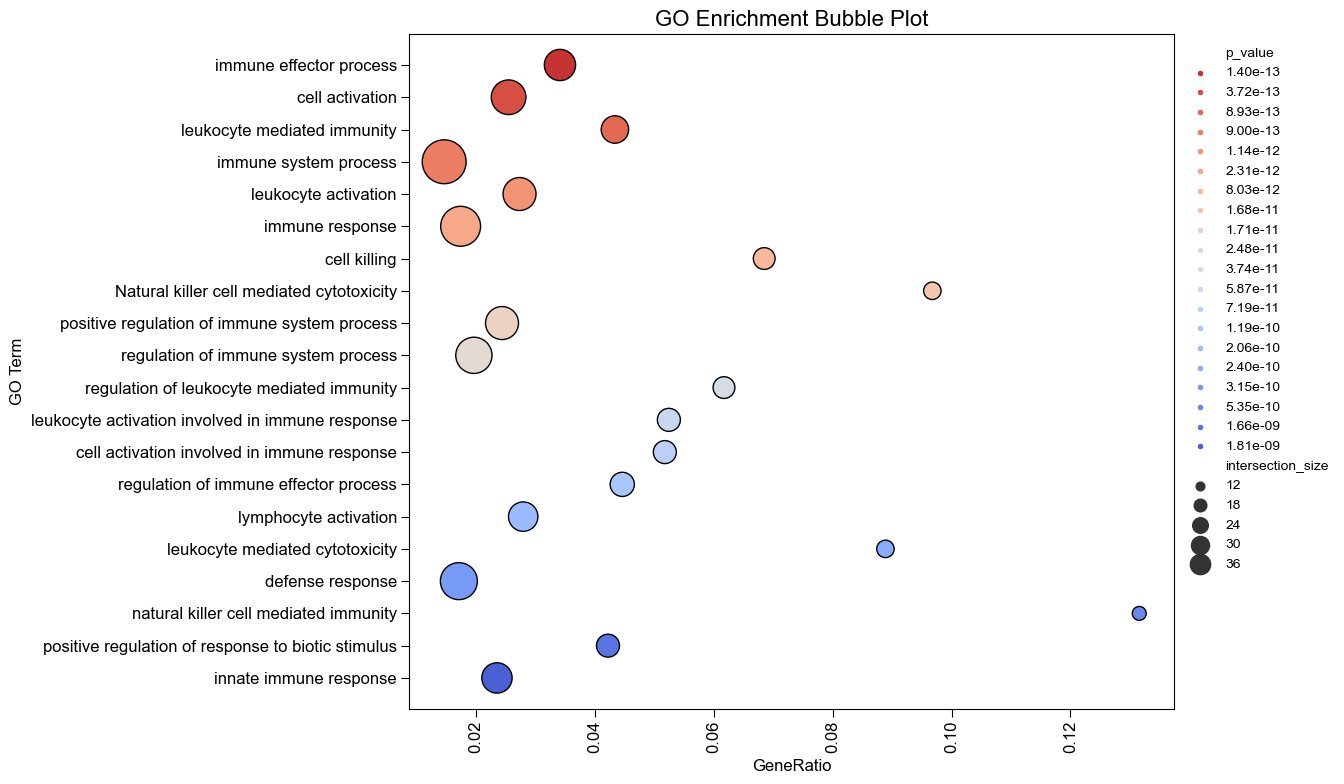

In [204]:
upregulated_high = markers[(markers['cluster'] == 'high')]['Gene'].unique().tolist()

# Initialize GProfiler for GO analysis
gp = GProfiler(return_dataframe=True)

# Perform GO analysis for upregulated genes in Cluster 0
go_results = gp.profile(organism='hsapiens', query=upregulated_high)
create_bubble_plot(go_results, "GO Enrichment Bubble Plot")

In [209]:
# Step 1: Get LEL values
lel_values = adata_cd8.obs['LDT_DSL']

# Step 2: Compute number of cells for 10%
n_cells = len(lel_values)
n_10pct = int(n_cells * 0.10)

# Step 3: Identify top and bottom 10% cells
top_10pct_cells = lel_values.sort_values(ascending=False).head(n_10pct).index
bottom_10pct_cells = lel_values.sort_values().head(n_10pct).index

 # Subset RNA data
high_rna = adata_cd8[adata_cd8.obs_names.isin(top_10pct_cells)].copy()
low_rna = adata_cd8[adata_cd8.obs_names.isin(bottom_10pct_cells)].copy()
high_rna.obs['group'] = 'high'
low_rna.obs['group'] = 'low'

# Combine and run DEG
combined = sc.concat([high_rna, low_rna], label='group', keys=['high', 'low'], index_unique=None)

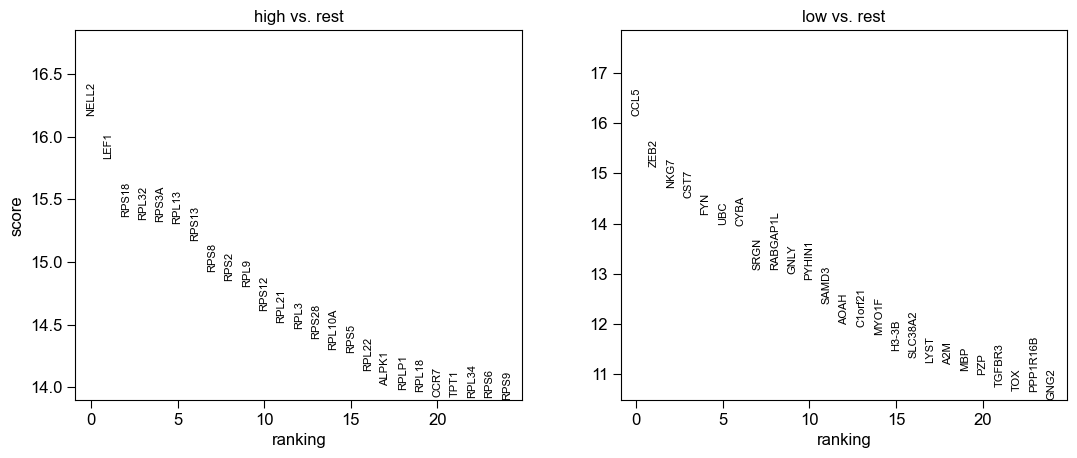

In [210]:
sc.tl.rank_genes_groups(combined, groupby="group", method="wilcoxon")
sc.pl.rank_genes_groups(combined, n_genes=25, sharey=False) 

In [218]:
#convert to dataframe
results = combined.uns['rank_genes_groups']
('0', '1', '2', '3', '4')

out = np.array([[0,0,0,0,0]])
for group in results['names'].dtype.names:
    out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group])).astype('object'))).T))



markers = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'lfc', 'cluster'])

markers = markers[(markers.pval_adj < 0.05) & (markers.lfc > 2)]

In [ ]:
upregulated_high = markers[(markers['cluster'] == 'high')]['Gene'].unique().tolist()

# Initialize GProfiler for GO analysis
gp = GProfiler(return_dataframe=True)

# Perform GO analysis for upregulated genes in Cluster 0
go_results = gp.profile(organism='hsapiens', query=upregulated_high)
create_bubble_plot(go_results, "GO Enrichment Bubble Plot")

GESA

In [510]:
#read data
pbmc_corr = pd.read_csv('GPS/20250521/pbmc_corr_lectin_hvg.csv', index_col=0)
cd4_corr = pd.read_csv('GPS/20250521/CD4T_hvg_lectin_corr.csv', index_col=0)
cd8_corr = pd.read_csv('GPS/20250521/CD8T_lectin_hvg_corr.csv', index_col=0)
nk_corr = pd.read_csv('GPS/20250521/NK_lectin_hvg_corr.csv', index_col=0)

In [532]:
import gseapy as gp

def run_gsea_for_lectin(df, lectin_name, gene_sets='GPS/20250521/gsea_results/c5.go.bp.v2025.1.Hs.symbols.gmt',
                        output_dir="GPS/20250521/gsea_results",filter_term=None, top_n_abs=1000):
    """
    Run pre-ranked GSEA using correlation between genes (index) and a lectin.

    Parameters:
    - df: pandas DataFrame with genes in the index and lectin correlations in columns
    - lectin_name: str, name of the lectin (e.g., "PHA-L")
    - output_dir: str, where to save results
    - filter_term: str, term to filter GO results (e.g., "T_CELL_ACTIVATION")

    Returns:
    - DataFrame of filtered GSEA results
    """
    if lectin_name not in df.columns:
        raise ValueError(f"{lectin_name} not found in DataFrame columns.")

    # Extract gene-score pairs from index and lectin column
    # Step 1: Select top genes by absolute correlation
    rnk = df[[lectin_name]].dropna().copy()
    rnk.columns = ["Score"]
    rnk["Gene"] = rnk.index
    rnk["abs_score"] = rnk["Score"].abs()
    top_genes = rnk.sort_values("abs_score", ascending=False).head(top_n_abs)["Gene"].values

    # Step 2: Subset and rank by signed correlation (normal Score)
    rnk = rnk[rnk["Gene"].isin(top_genes)].sort_values("Score", ascending=False)
    rnk = rnk[["Gene", "Score"]]

    # Prepare output directories and filenames
    lectin_dir = os.path.join(output_dir, lectin_name.replace(" ", "_"))
    os.makedirs(lectin_dir, exist_ok=True)
    rnk_path = os.path.join(lectin_dir, f"{lectin_name}_ranked.rnk")
    rnk.to_csv(rnk_path, sep="\t", index=False, header=False)

    # Run GSEApy prerank
    pre_res = gp.prerank(
        rnk=rnk_path,
        gene_sets=gene_sets,
        outdir=lectin_dir,
        format='png',
        min_size=15,
        max_size=500,
        permutation_num=1000,
        seed=42,
        verbose=True,
    )

    # Filter for terms matching query
    res_df = pre_res.res2d.copy()
    res_df.index = res_df.index.astype(str)
    
    if filter_term:
        filtered_df = res_df[res_df.index.str.contains(filter_term, case=False)]
        return filtered_df, pre_res

    return res_df, pre_res

In [811]:
results_df, pre_res = run_gsea_for_lectin(pbmc_corr, "PHA-L")

2025-07-14 13:19:36,869 [INFO] Parsing data files for GSEA.............................
2025-07-14 13:19:37,080 [INFO] 7026 gene_sets have been filtered out when max_size=500 and min_size=15
2025-07-14 13:19:37,080 [INFO] 0557 gene_sets used for further statistical testing.....
2025-07-14 13:19:37,081 [INFO] Start to run GSEA...Might take a while..................
2025-07-14 13:19:43,555 [INFO] Congratulations. GSEApy runs successfully................



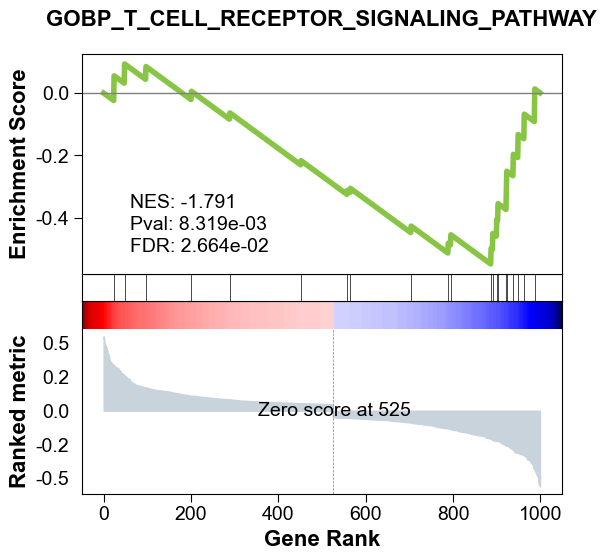

In [814]:
from gseapy.plot import gseaplot

term = "GOBP_T_CELL_RECEPTOR_SIGNALING_PATHWAY"

gseaplot(
    rank_metric=pre_res.ranking,
    term=term,
    **pre_res.results[term]
)

plt.savefig(save_dir + "gsea_plot_cd4_tcr.svg", format="svg", bbox_inches='tight', pad_inches=0)

In [812]:
T_cell_terms = results_df[results_df["Term"].str.contains("T_CELL", case=False)]

In [813]:
T_cell_terms

Name                                               Term        ES  \
70   prerank             GOBP_T_CELL_RECEPTOR_SIGNALING_PATHWAY -0.546001   
84   prerank                             GOBP_T_CELL_ACTIVATION -0.396452   
120  prerank                  GOBP_ALPHA_BETA_T_CELL_ACTIVATION -0.430576   
139  prerank                      GOBP_FAT_CELL_DIFFERENTIATION -0.452475   
147  prerank                      GOBP_T_CELL_MEDIATED_IMMUNITY -0.478632   
148  prerank                        GOBP_T_CELL_DIFFERENTIATION  0.332467   
183  prerank               GOBP_REGULATION_OF_T_CELL_ACTIVATION -0.332779   
206  prerank  GOBP_T_CELL_ACTIVATION_INVOLVED_IN_IMMUNE_RESP...  -0.41084   
252  prerank    GOBP_REGULATION_OF_ALPHA_BETA_T_CELL_ACTIVATION -0.385104   
367  prerank                          GOBP_T_CELL_PROLIFERATION -0.306185   
389  prerank             GOBP_ALPHA_BETA_T_CELL_DIFFERENTIATION -0.313448   
491  prerank     GOBP_CD4_POSITIVE_ALPHA_BETA_T_CELL_ACTIVATION -0.273289   

          NES NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
70  -1.790995  0.008319  0.026638      0.542  10/21  11.40%   
84  -1.697276  0.008759  0.050677       0.79  31/75  17.40%   
120 -1.526945  0.042208   0.13435      0.982  10/29  11.80%   
139  -1.45223  0.078498  0.186385      0.996   7/20  16.60%   
147 -1.421806  0.089679  0.211345      0.998   9/15  18.50%   
148  1.415683  0.047619       1.0      0.983  14/42  13.30%   
183 -1.331873  0.113671  0.286823        1.0  20/53  17.40%   
206 -1.284286  0.158678  0.328692        1.0   6/18  11.40%   
252 -1.215948  0.240401  0.378912        1.0   7/19  17.40%   
367   -1.0423  0.417077  0.553712        1.0   9/23  18.50%   
389 -1.009585  0.447154  0.591173        1.0   5/19  11.40%   
491 -0.840029  0.668367  0.761794        1.0   2/17   3.70%   

                                            Lead_genes  
70   PLCG2;PTPRJ;TRDC;SLA2;PTPN22;CD300A;HLA-DPB1;T...  
84   NKG7;KLRK1;TYROBP;SLAMF7;LYN;KLRF1;CCL5;TOX;FC...  
120  NKG7;KLRF1;TOX;EOMES;SYK;CD300A;ZBTB16;LILRB1;...  
139          CTBP2;METRNL;TRIO;ZBTB16;CEBPD;ID2;DUSP10  
147  KLRD1;PRF1;KLRC1;LILRB1;CD8A;HLA-DRB1;CRTAM;HL...  
148  CAMK4;IL7R;THEMIS;ZEB1;BCL2;SOS1;RORA;RUNX2;LE...  
183  KLRK1;LYN;CCL5;TOX;TIGIT;CD74;SYK;MAP3K8;PTPN2...  
206           TYROBP;FCER1G;EOMES;CD74;LILRB1;HLA-DRB1  
252    SYK;CD300A;ZBTB16;LILRB1;HLA-DRB1;CRTAM;HLA-DRA  
367  CCL5;SYK;HLA-DPB1;LILRB1;HLA-DRB1;CRTAM;DLG5;H...  
389                      TOX;EOMES;SYK;ZBTB16;HLA-DRB1  
491                                           NKG7;TOX

In [232]:
cytotoxicity = results_df[results_df["Term"].str.contains("adaptive", case=False)]

In [747]:
results_df

Name                                              Term        ES  \
0    prerank        GOBP_NATURAL_KILLER_CELL_MEDIATED_IMMUNITY  0.753619   
1    prerank               GOBP_REGULATION_OF_DEFENSE_RESPONSE  0.451435   
2    prerank         GOBP_REGULATION_OF_INNATE_IMMUNE_RESPONSE  0.510232   
3    prerank                 GOBP_DEFENSE_RESPONSE_TO_SYMBIONT  0.439637   
4    prerank  GOBP_REGULATION_OF_RESPONSE_TO_EXTERNAL_STIMULUS  0.400089   
..       ...                                               ...       ...   
582  prerank            GOBP_ORGANIC_ACID_BIOSYNTHETIC_PROCESS -0.159388   
583  prerank                GOBP_RECEPTOR_MEDIATED_ENDOCYTOSIS  0.121362   
584  prerank  GOBP_REGULATION_OF_SYNAPSE_STRUCTURE_OR_ACTIVITY  -0.13362   
585  prerank                   GOBP_MICROTUBULE_BASED_MOVEMENT -0.107634   
586  prerank                  GOBP_MICROTUBULE_BASED_TRANSPORT  0.119797   

          NES NOM p-val FDR q-val FWER p-val   Tag %  Gene %  \
0    3.257541       0.0       0.0        0.0   14/19  13.10%   
1    3.007413       0.0       0.0        0.0   28/77  10.80%   
2    3.002188       0.0       0.0        0.0   24/50  14.00%   
3    2.979043       0.0       0.0        0.0   38/93  14.00%   
4    2.910993       0.0  0.000246      0.001  44/108  16.80%   
..        ...       ...       ...        ...     ...     ...   
582 -0.606262  0.904682  0.933316        1.0    3/17  10.60%   
583  0.599526  0.945813  0.942135        1.0    5/28  13.20%   
584 -0.515491  0.971947  0.977205        1.0    6/17  30.00%   
585 -0.514543  0.971108  0.974454        1.0   16/31  47.90%   
586   0.46973    0.9825  0.990942        1.0   15/15  88.20%   

                                            Lead_genes  
0    SH2D1B;KLRD1;NKG7;TYROBP;NCR1;KLRK1;LYST;GZMB;...  
1    AOAH;GBP5;SH2D1B;KLRD1;TNFAIP3;APOBEC3G;NKG7;T...  
2    GBP5;SH2D1B;KLRD1;TNFAIP3;TYROBP;NCR1;KLRK1;CC...  
3    GBP5;GNLY;SH2D1B;KLRD1;TNFAIP3;APOBEC3G;NKG7;T...  
4    AOAH;GBP5;SH2D1B;KLRD1;TNFAIP3;APOBEC3G;NKG7;T...  
..                                                 ...  
582                              SERINC5;MTHFD1L;ABCD2  
583                         PLCG2;FCER1G;RIN3;MX2;HIP1  
584                  PRKCA;PTPN13;EPHA4;LRRN3;SNCA;TNF  
585  CFAP210;KIF5C;RPGR;SPA17;SPAG16;DST;CFAP70;PAC...  
586  KIF13A;FEZ1;RAB27B;DNAAF11;LCA5;CFAP54;DLG2;JH...  

[587 rows x 10 columns]

In [206]:
cytotoxicity

Name                                               Term        ES  \
61   prerank                      GOBP_ADAPTIVE_IMMUNE_RESPONSE  0.449487   
332  prerank  GOBP_ADAPTIVE_IMMUNE_RESPONSE_BASED_ON_SOMATIC...  0.308137   
499  prerank  GOBP_POSITIVE_REGULATION_OF_ADAPTIVE_IMMUNE_RE... -0.212775   
572  prerank        GOBP_REGULATION_OF_ADAPTIVE_IMMUNE_RESPONSE  0.220157   

          NES NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
61   1.694776  0.001058  0.056369      0.769  31/75  20.30%   
332  1.073783  0.381637  0.696782        1.0  10/44  14.20%   
499 -0.856468     0.635  0.884568        1.0   3/18   4.60%   
572   0.72119  0.836639  0.913198        1.0   4/31   9.50%   

                                            Lead_genes  
61   KLRD1;PRF1;KLRK1;SLAMF7;LYN;KLRC2;SLA2;SH2D1B;...  
332  KLRD1;PRF1;SLA2;FCER1G;KLRC1;LILRB1;FCGR3A;CD8...  
499                               SLAMF1;CD55;TNFSF13B  
572                          KLRD1;FCER1G;KLRC1;LILRB1

In [221]:
adhesion_terms = results_df[results_df["Term"].str.contains("migration", case=False)]

In [222]:
adhesion_terms

Name                                               Term        ES  \
38   prerank                           GOBP_LEUKOCYTE_MIGRATION -0.525085   
41   prerank                   GOBP_MYELOID_LEUKOCYTE_MIGRATION -0.564366   
57   prerank             GOBP_REGULATION_OF_LEUKOCYTE_MIGRATION  -0.51003   
101  prerank                         GOBP_GRANULOCYTE_MIGRATION -0.492897   
103  prerank      GOBP_REGULATION_OF_MONONUCLEAR_CELL_MIGRATION  -0.47967   
105  prerank                    GOBP_MONONUCLEAR_CELL_MIGRATION -0.462892   
158  prerank                 GOBP_AMEBOIDAL_TYPE_CELL_MIGRATION -0.453126   
228  prerank    GOBP_POSITIVE_REGULATION_OF_LEUKOCYTE_MIGRATION  -0.37947   
253  prerank                              GOBP_NEURON_MIGRATION -0.420576   
256  prerank  GOBP_POSITIVE_REGULATION_OF_MONONUCLEAR_CELL_M...  -0.38267   
288  prerank                    GOBP_ENDOTHELIAL_CELL_MIGRATION -0.375041   

          NES NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
38  -2.225574       0.0  0.000423      0.011  22/43  17.80%   
41  -2.173759       0.0  0.001144      0.026  16/28  17.80%   
57  -2.014095       0.0  0.005739       0.15  16/30  19.50%   
101 -1.719252  0.017212  0.051052      0.805  10/20  17.80%   
103 -1.712728  0.008897  0.052417       0.81   8/21  10.70%   
105 -1.702279  0.012658  0.055766      0.834  11/24  17.80%   
158 -1.530368  0.055749  0.120449      0.991   5/17  11.50%   
228 -1.371493  0.103918  0.209894        1.0   9/21  19.50%   
253 -1.306528  0.154717   0.26084        1.0   4/15  10.00%   
256 -1.295807   0.17103  0.270606        1.0   7/17  17.80%   
288 -1.236388  0.226316  0.326615        1.0   4/16  10.00%   

                                            Lead_genes  
38   LYN;FCER1G;LYST;CCL5;VAV3;KLRK1;SYK;RIN3;CD300...  
41   LYN;FCER1G;CCL5;VAV3;SYK;RIN3;CD300A;PLCB1;PTP...  
57   LYN;CCL5;KLRK1;RIN3;CD300A;PLCB1;PTPRJ;PDGFD;S...  
101  FCER1G;CCL5;VAV3;SYK;CD300A;PTPRJ;CCL4;CD74;IT...  
103        LYN;CCL5;KLRK1;PLCB1;PTPRJ;PDGFD;PTK2B;CCL4  
105  LYN;CCL5;KLRK1;PLCB1;PTPRJ;PDGFD;PTK2B;CCL4;CX...  
158                      ZEB2;PLCG2;DOCK5;PRR5L;DUSP10  
228  CCL5;PTPRJ;PDGFD;PTK2B;CCL4;CD74;CX3CR1;CCL3;T...  
253                           AUTS2;EOMES;ADGRG1;PTK2B  
256            CCL5;PTPRJ;PDGFD;PTK2B;CCL4;CX3CR1;CCL3  
288                             ZEB2;TGFBR3;GAB1;PTK2B